### contents:

1. Word frequencies
<br>What's the speech average length and unique words count?
<br>Which words are more common per word category (noun, adjective and verb)?
<br>Are verbs used more or less than nouns? 
<br> Which are the most common ngrams?

2. Named Entities
<br>Which types of words usually accompany certain NEs?
<br>Which are the most common NEs for person, organization and geopolitical entities?

3. Word distributions
<br>Do certain words appear evenly distributed through the speeches or is it more a temporary usage?
<br>How two or more words compare in frequency distribution?
<br>Do certain words appear in the same context?

4. Sentiment
<br>Which is the overall sentiment?
<br>Which is the sentiment flow within the speeches? Is there a pattern?
<br>Which sentiment usually describes a certain NE?

### setup:

In [2]:
!pip install chart-studio==1.1.0

     |████████████████████████████████| 64 kB 298 kB/s eta 0:00:011
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [9]:
import os
import re
import datetime
import random

import spacy 
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import pandas as pd
import numpy as np
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer

from wordcloud import WordCloud
import matplotlib 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import chart_studio
import chart_studio.plotly as py
chart_studio.tools.set_credentials_file(username='******', api_key='*********')
from plotly.offline import iplot
import plotly.express as px
import plotly.graph_objects as go
from yellowbrick.text import DispersionPlot, dispersion, FreqDistVisualizer

In [4]:
path = '../input/donald-trumps-rallies'
nlp = spacy.load("en_core_web_sm")
stopwords = stopwords.words('english')

### utils:

In [5]:
def get_speeches(path):
    """
    Open all txt files.
    
    Returns : list of lists
    """
    speeches = []
    
    for file in os.listdir(path):
        with open(os.path.join(path, file), 'r', encoding='utf-8') as f:
            speeches += f.readlines()
            
    return speeches


def get_metadata(path):
    """
    Get location and date of each speech.
    
    Returns : tuple (str, str)
    """
    metadata = []
    
    for filename in os.listdir(path):
        mt = re.match("(^[A-Z]{1}[a-zA-Z-?]+)([A-Za-z]{3}[0-9]{1,2}_[0-9]{4})", filename)
        if mt:
            metadata.append(mt.groups())
            
    return metadata

In [6]:
def format_strings(data):
    """
    Add space to strings of the type "NewYork" to get "New York".
    
    data : tuple
        Data returned by get_metadata().
    
    Returns : list 
        Formatted strings.
    """
    
    strings = []
    
    for d in data:
        string = re.match("(^[A-Z][a-z]+)([A-Z][a-z]+$)", d[0])
        if string:
            strings.append(' '.join(string.groups()))
        else:
            strings.append(d[0])

    return strings            

In [7]:
locations = pd.Series(format_strings(get_metadata(path)))
dates = pd.to_datetime(pd.Series([mt[1] for mt in get_metadata(path)]), format="%b%d_%Y")

In [8]:
# List of documents : [doc1, doc2, doc3, ..., doc35]
speeches = [doc for doc in list(nlp.pipe(get_speeches(path)))]

In [7]:
print("Variable type: ", type(speeches))
print("Variable elements type: ", type(speeches[0]))

Variable type:  <class 'list'>
Variable elements type:  <class 'spacy.tokens.doc.Doc'>


In [8]:
def words_per_pos(docs, attribute, pos, get_most_common='no', n_common=20):
    """
    Get all words corresponding to a word's PoS. 
    Stopwords not included (otw see all_words_per_doc).

    docs : list of spaCy Doc
        Corpus.
        
    attribute : str
        spaCy token attribute to return, 'lemma' or 'text'.
        
    pos : str
        Word class we want to return, 'ADJ', 'NOUN' or 'VERB'.
        
    get_most_common : str, default='no'
        'yes' to get only most common words. Otw, get all words.
        
    n_common : int
        Number of most common words to return if get_most_common = 'yes'.
    
    Returns : tuple ([words], [most_common_words])
    
        - words : all words in the corpus in the chosen form (lemma or text).
        
        - most_common_words : optional, if 'no' returns empty list.
    """
    words = []
    most_common_words = []
    
    for doc in docs:
        if attribute == 'lemma':
            result = [token.lemma_ for token in doc if token.is_stop != True and token.is_punct != True and token.pos_ == pos]
            words.append(result)
            
        elif attribute == 'text':
            result = [token.text for token in doc if token.is_stop != True and token.is_punct != True and token.pos_ == pos]
            words.append(result)
        
        if get_most_common == 'yes':
            most_common_words.append(Counter(result).most_common(n_common))
        
    return words, most_common_words

In [9]:
def all_words_per_pos(docs, pos):
    """
    Get all words corresponding to a word's PoS. 
    Stopwords included (otw see words_per_pos).
    
    Returns : list of lists
    """
    
    words = []
    
    for doc in docs:
        result = [token.lemma_ for token in doc if token.is_punct != True and token.pos_ == pos]
        words.append(result)
            
    return words

In [31]:
def all_words(docs):
    """
    Get all tokens in every text that, in oral speech, would become uttered words.
    
    Returns : list
        All word lemmas (except for pronouns, in which case are normalized forms).
    """
    words = []
    
    for doc in docs:
        temp_words = []
        
        for token in doc:
            if token.is_punct != True:
                if token.lemma_ != "-PRON-":
                    temp_words.append(token.lemma_)
                else:
                    temp_words.append(token.norm_)

        words.append(temp_words)
        
    return words

# 1. Word frequencies

### 1.1 Speech length and unique words count

In [11]:
total_words = all_words(speeches)
unique_words = [set(words) for words in total_words]

sum_all_words = sum([len(doc) for doc in total_words])
sum_unique_words = sum([len(doc) for doc in unique_words])

In [12]:
vocab = pd.DataFrame(
    {"date": dates, 
     "location": locations,
     "total words": pd.Series([len(doc) for doc in total_words]), 
     "unique words": pd.Series([len(doc) for doc in unique_words]),
    }).sort_values(by=['date']).reset_index(drop=True)

to_fig = vocab.drop(columns=["date", "location"])

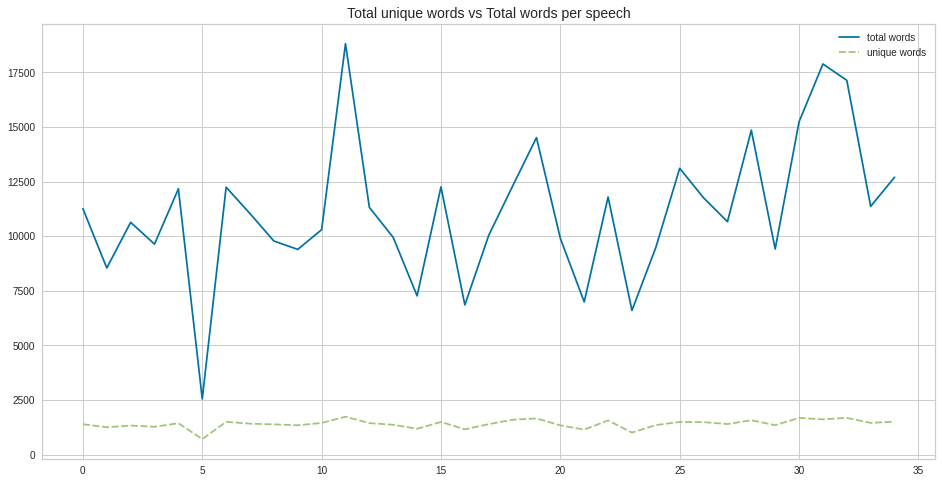

In [13]:
plt.figure(figsize=(16,8))
plt.title("Total unique words vs Total words per speech", fontsize=14)
sns.lineplot(data=to_fig);

### 1.2 Which words are more common per word class (noun, adjective and verb)? 

In [14]:
adjs, most_common_adjs = words_per_pos(speeches, 'lemma', 'ADJ', get_most_common='yes', n_common=20)
nouns, most_common_nouns = words_per_pos(speeches, 'lemma', 'NOUN', get_most_common='yes', n_common=20)
verbs, most_common_verbs = words_per_pos(speeches, 'lemma', 'VERB', get_most_common='yes', n_common=20)

In [15]:
def most_common_dict(common_words, max_length):
    """
    Convert most_common_words, as given by words_per_pos(), 
    into a dictionary of length max_length.
    
    Returns : dict
    
        - keys : most common words
        
        - values : total count of times recorded in all speeches
    """

    most_common = dict()

    for lst in common_words:
        for word, count in lst:
            if word not in most_common.keys():
                most_common[word] = 0
            most_common[word] += count
    
    return dict(sorted(most_common.items(), key=lambda d:d[1], reverse=True)[:max_length])

In [16]:
nouns_top20 = most_common_dict(most_common_nouns, 20)
adjs_top20 = most_common_dict(most_common_adjs, 20)
verbs_top20 = most_common_dict(most_common_verbs, 20)

In [17]:
nouns_20df = pd.DataFrame({"nouns": nouns_top20.keys(), "counts": nouns_top20.values()})
adjs_20df = pd.DataFrame({"adjectives": adjs_top20.keys(), "counts": adjs_top20.values()})
verbs_20df = pd.DataFrame({"verbs": verbs_top20.keys(), "counts": verbs_top20.values()})

In [18]:
def plot_20top(df, word_class):
    
    plt.figure(figsize=(12,6))
    sns.set_context("talk", rc={"axes.labelsize":24})
    b = sns.barplot(x=df[word_class], y=df.counts, color=random.choice(sns.color_palette("husl", 9)))
    plt.xticks(rotation=80)
    b.axes.set_title(f'20 Most Common {word_class.title()} in Trump Rallies (2019-2020)',fontsize=18)
    b.set_ylabel('counts', fontsize=18)
    b.set_xlabel('');

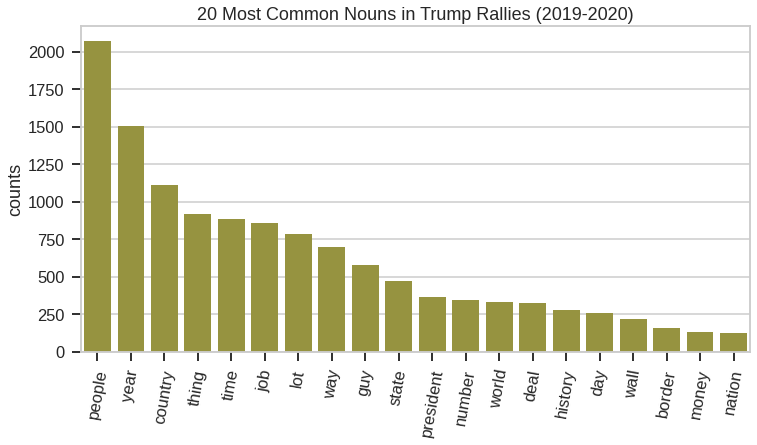

In [29]:
plot_20top(nouns_20df, 'nouns')

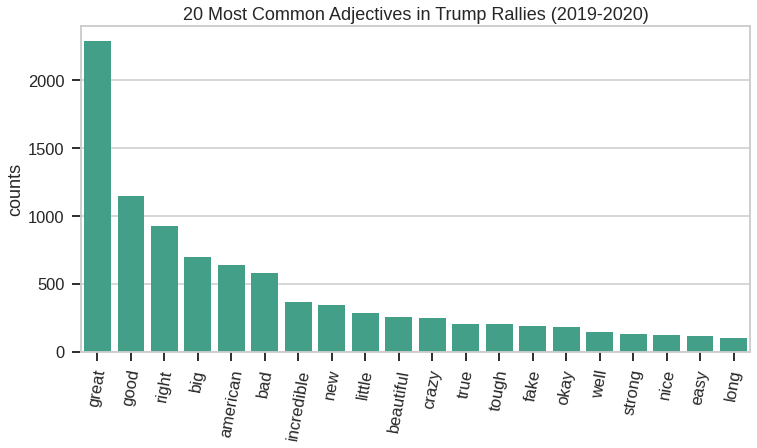

In [20]:
plot_20top(adjs_20df, 'adjectives')

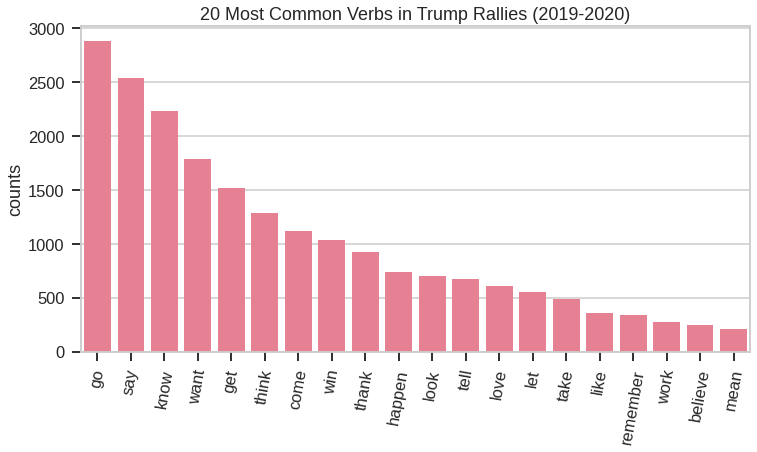

In [24]:
plot_20top(verbs_20df, 'verbs')

In [30]:
total_share = ((sum(nouns_top20.values()) + sum(adjs_top20.values()) + sum(verbs_top20.values())) / sum_all_words) * 100
perc = (60 / sum_unique_words) * 100
print(f"These 60 most common words combined account for >>> {total_share:.2f}% <<< of a total of {sum_all_words:,} words.")
print(f"That is, >>> {perc:.2f}% <<< of the unique words account for {total_share:.2f}% of the oral text. ")

These 60 most common words combined account for >>> 10.83% <<< of a total of 389,756 words.
That is, >>> 0.12% <<< of the unique words account for 10.83% of the oral text. 


### 1.3 Are verbs used more or less than nouns? 

Following [Carlos Ahumada's analysis](https://towardsdatascience.com/nlp-using-spacyr-to-analyze-presidential-speeches-49c10ef37aef)  — inspired by the work of Michal Reifen-Tagar and Orly Idan ([2018](https://journals.sagepub.com/doi/abs/10.1177/0956797618772823?journalCode=pssa))  — on the relation noun/verb ratio with the amount of tension in the political discourse, we obserse the following results. Surprinsingly (or not), from the 1.24 that Ahumada records in his analysis for Trump's inaugural speech, **the average noun/verb ratio we get** for our selection of 35 rally speeches **drops to 0.91**.

In [31]:
nouns_share = (sum([len(lst) for lst in all_words_per_pos(speeches, 'NOUN')]) / sum_all_words) * 100
verbs_share = (sum([len(lst) for lst in all_words_per_pos(speeches, 'VERB')]) / sum_all_words) * 100

print(f"The average noun/verb ratio is of {nouns_share / verbs_share:.2f}")

The average noun/verb ratio is of 0.91


In [32]:
nouns_speech = pd.Series([len(lst) for lst in all_words_per_pos(speeches, 'NOUN')])
verbs_speech = pd.Series([len(lst) for lst in all_words_per_pos(speeches, 'VERB')])
nouns_verbs = pd.DataFrame({"date": dates, "location": locations, "nouns": nouns_speech, "verbs": verbs_speech}).sort_values(by=['date']).reset_index(drop=True)
nouns_verbs['ratio'] = pd.Series(nouns_verbs.nouns / nouns_verbs.verbs).round(2)

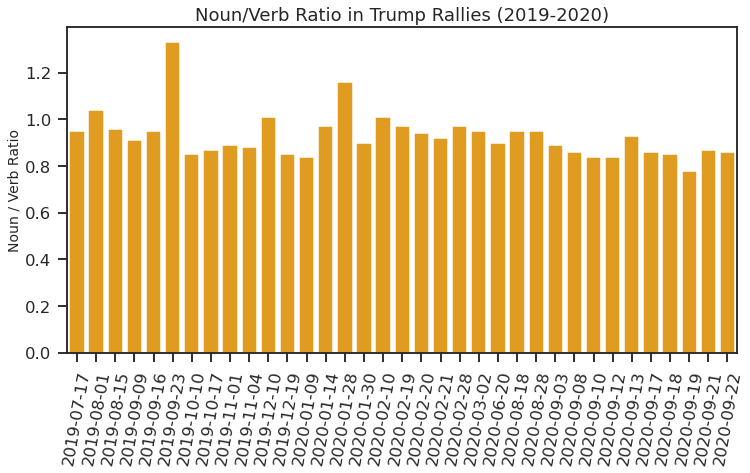

In [33]:
plt.figure(figsize=(12,6))
sns.set_style("ticks")
b = sns.barplot(x=nouns_verbs.date.astype(str), y=nouns_verbs.ratio, color='orange')
plt.xticks(rotation=80)
b.axes.set_title('Noun/Verb Ratio in Trump Rallies (2019-2020)',fontsize=18)
b.set_xlabel('')
b.set_ylabel('Noun / Verb Ratio',fontsize=14);

### 1.4 Which are the most common ngrams?

In [34]:
def plot_freq_dist(ngram_range, data, orient='h', size=(1620,1080), stopwords=stopwords):
    """
    Get plot of ngrams frequency distribution.
    Function dependent on yellowbrick.text.
    
    ngram_range : tuple
        Length of groups of tokens to be extracted from the corpus.
        E.g. (2, 2) for bigrams or (3, 3) for trigrams.
        
    data : iterable
        Corpus to be distributed.
    
    orient : str, default='h'
        'h' for horizontal, 'v' for vertical orientation of the plot.
    
    size : tuple, default=(1620,1080)
        Size in pixels.
    
    stopwords : set, list, default=nltk.corpus.stopwords.words('english')
        Words not to take into account for the distribution.
        To include all words, stopwords=None.
        
    Returns : plot
        Frequency distribution of top 50 ngrams.
    """

    vectorizer = CountVectorizer(stop_words=stopwords, ngram_range=ngram_range)

    docs = vectorizer.fit_transform(data)
    features = vectorizer.get_feature_names()

    visualizer = FreqDistVisualizer(features=features, orient=orient, size=size)
    visualizer.fit(docs)
    visualizer.show();

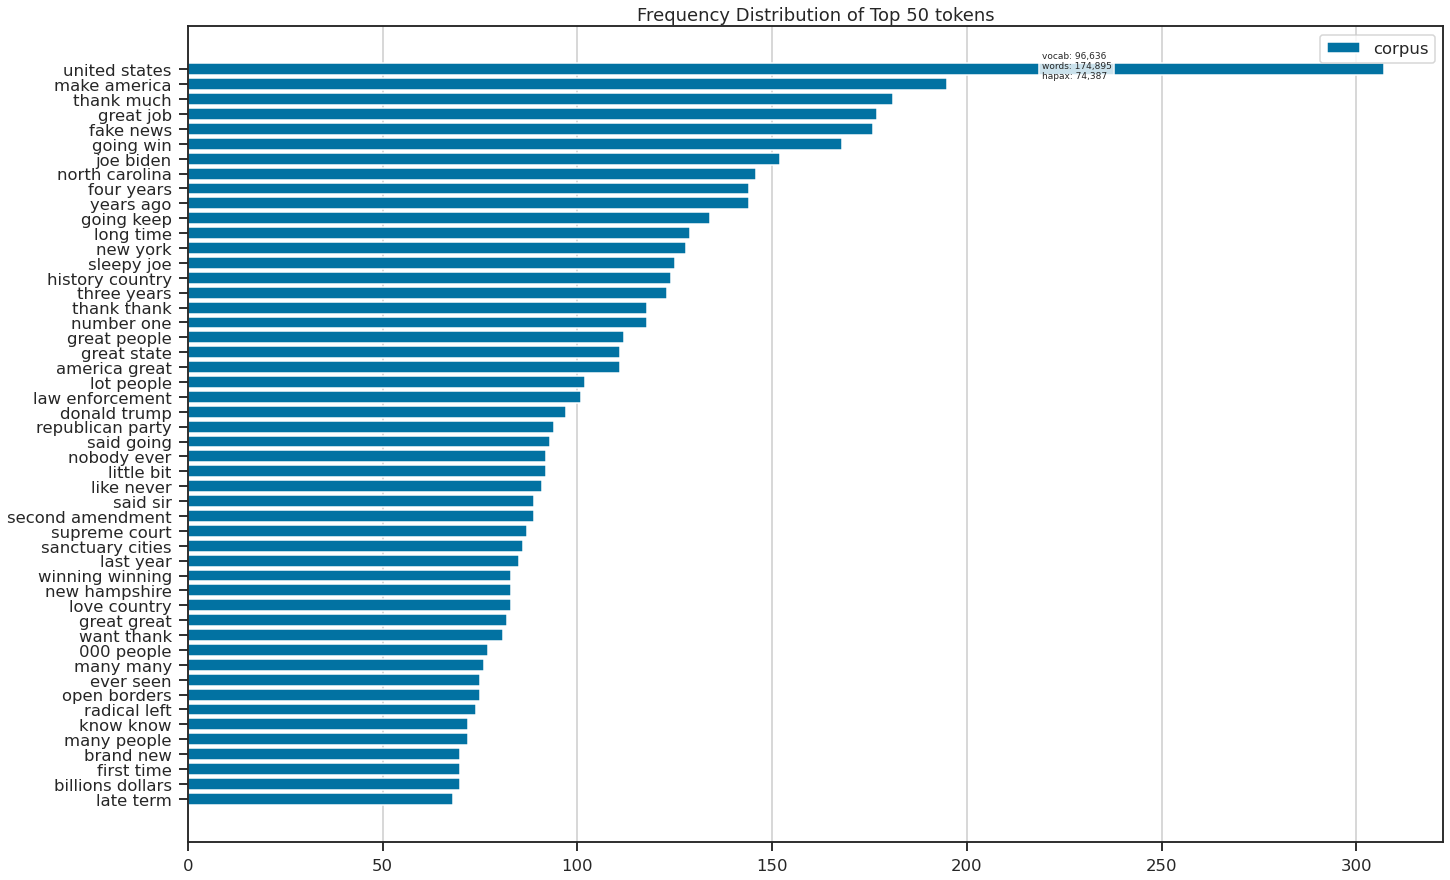

In [35]:
plot_freq_dist((2,2), get_speeches(path))

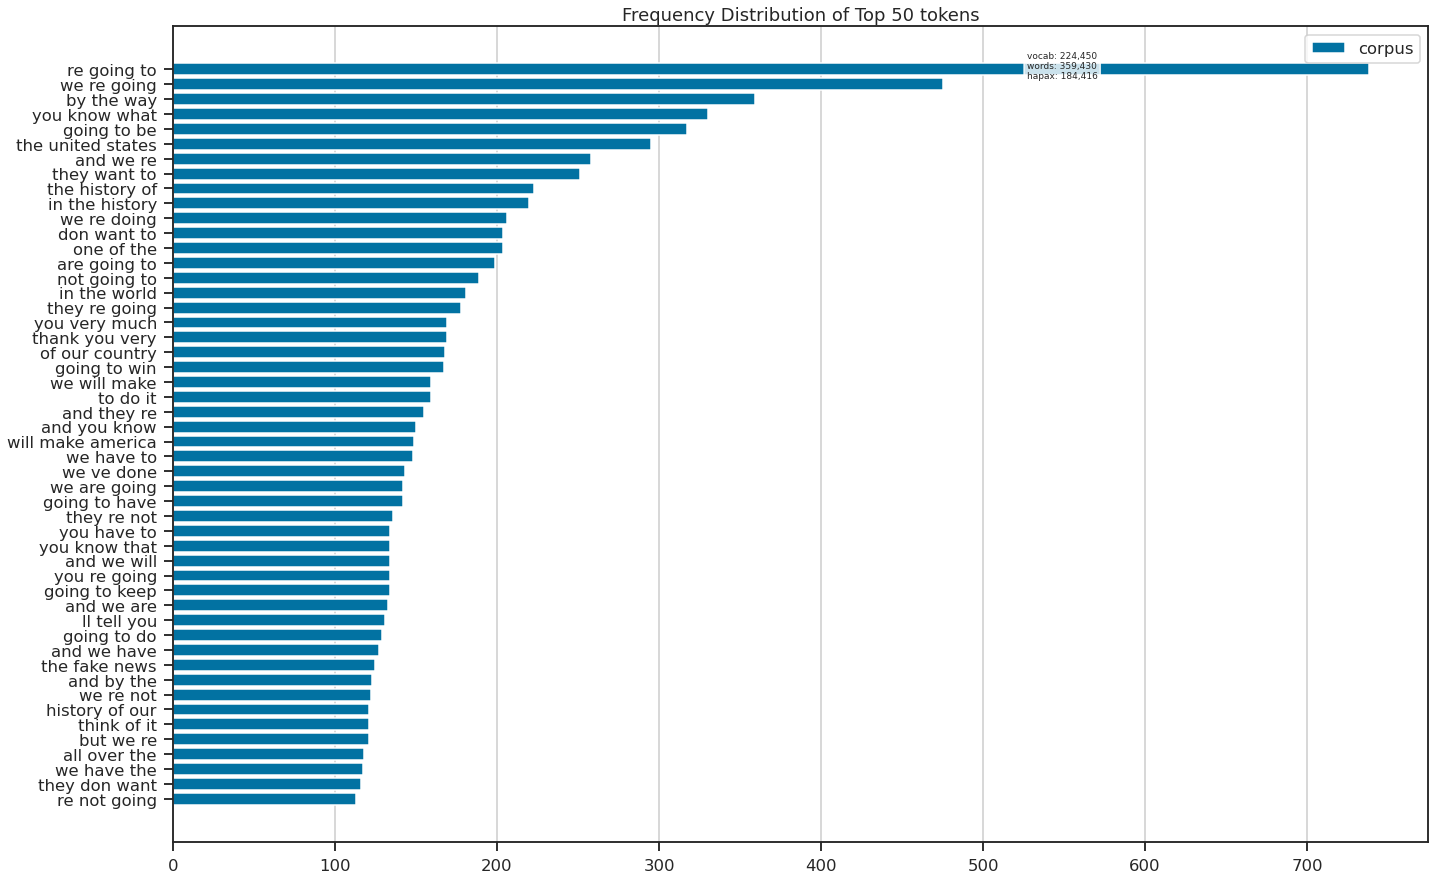

In [36]:
plot_freq_dist((3,3), get_speeches(path),stopwords=None)

# 2. Named Entities

### 2.1 Which types of words usually accompany certain NEs?

In [57]:
def get_acc_words(docs, keyword, pos, position=5, n=20):
    """
    Get all accompanying words of a chosen class.
    
    docs : list of spaCy Doc
        Corpus.
        
    keyword : str
        Token to search for its accompanying words.
        
    pos : str
        Word class of the accompanying words to collect.
        
    position : int, default=5
        Number of words to the left and right of the keyword.
        
    n : int, default=20
        Number of words to include in the list of most common.
    
    Returns : tuple ("acc_words", [acc_most_common], [mentions]) 
    
        - acc_words : str 
            All accompanying word lemmas with the selected PoS within the selected span of text.
            
        - acc_most_common : list of tuples
            n most words from acc_words.
            
        - mentions : list
            Spans of text where the keyword is contained.
    """

    acc_words = []
    mentions = []
    
    for doc in docs:
        for token in doc:
            if token.text == keyword:
                span = doc[token.i - position : token.i + position+1]
                mentions.append(span)
                for token in span:
                    if token.pos_ == pos and token.is_punct == False and token.text != keyword:
                        acc_words.append(token.lemma_)
    
    acc_most_common = Counter(acc_words).most_common(n)
    acc_words = ",".join(acc_words)

    return acc_words, acc_most_common, mentions

In [38]:
def plot_wordcloud(words, width=1500, height=1000, background_color="black", colormap="Set2"):
    """
    Plot WordCloud visualization of the accompanying words of a Named Entity.
    Doesn't include repeated words or stopwords.
    
    words : str
        Accompanying words obtained with get_acc_words().
        
    other arguments : optional customization
    
    Returns : WordCloud representation ☁️
    """
    plt.figure(figsize=(20, 15))
    plt.axis("off")
    wordcloud = WordCloud(width=width, 
                          height=height, 
                          random_state=1, 
                          background_color=background_color, 
                          colormap=colormap,
                          collocations=False,
                          stopwords=stopwords).generate(words)
    plt.imshow(wordcloud);

In [45]:
keyword = "Biden"

In [46]:
acc_example, mc_example, mentions_example = get_acc_words(speeches, keyword, "ADJ")

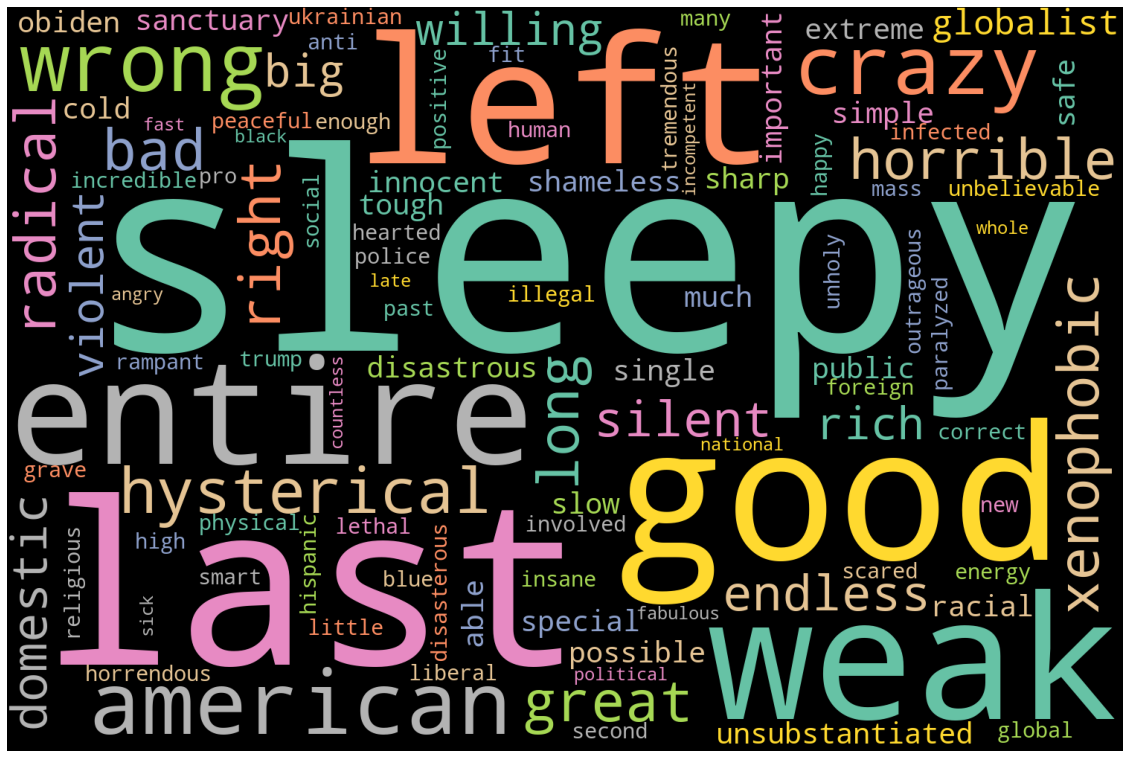

In [47]:
plot_wordcloud(acc_example)

### 2.2 Which are the most common NEs for person, organization and geopolitical entities? 

In [10]:
def get_ents(docs, ent_search=["PERSON", "GPE", "ORG"]):
    """
    Get chosen Named Entities from a list of spaCy Docs.
    Depends on rename_ent().
    
    Returns : dict
    
        - keys : chosen NE.
        
        - values : corresponding search results.
    """
    
    ents_dict = dict()
    ent_search = ent_search
    
    for doc in docs:
        for ent in doc.ents:
            if ent.label_ in ent_search:
                if ent.label_ not in ents_dict.keys():
                    ents_dict[ent.label_] = []
                ents_dict[ent.label_].append(rename_ent(ent.text, ent.label_))
                
    return ents_dict

In order to get a meaningful visualization of the entities mentioned in Trump's rallies, we normalize the most common ones (after observation of original corresponding *short_df*s). 

In [11]:
def rename_ent(ent_text, ent_label):
    """
    Normalize different denominations to an entity under a single one.
    
    ent_text : str
        ent.text, text form of the NE.
        
    ent_label : str
        ent.label_, type of the NE.
    
    Returns : str
        Normalized ent.text if needed. Otherwise, original ent.text.
    """
    
    if ent_label == "PERSON":
        
        # Patterns to avoid
        Joe_Biden = re.compile(r"Pennacchio|Hunter|Wilson|Crowley|Kiernan")
        Donald_Trump = re.compile(r"Eric|Michael|Ass|Ivanka|pro|Barron|Jr|Has|Lara|Whippie")
        Bernie_Sanders = re.compile(r"Marcus|Sarah")
        Barack_Obama = re.compile(r"Michelle|Joe|Biden")
        Hillary_Clinton = re.compile(r"Bill")
        AOC = re.compile(r"Elizabeth")
        
        # Normalized PERSON ents:
        
        # Joe Biden
        if re.search(r"Joe|Biden", ent_text):
            if not re.search(Joe_Biden, ent_text):
                ent_text = ent_text.replace(ent_text, "Joe Biden")
        
        # Donald Trump
        if re.search(r"Donald|Trump", ent_text):
            if not re.search(Donald_Trump, ent_text):
                ent_text = ent_text.replace(ent_text, "Donald Trump")
            
        # Mike Pence
        if re.fullmatch(r"Mike|Pence", ent_text):
            ent_text = ent_text.replace(ent_text, "Mike Pence")
            
        # Kamala Harris
        if re.fullmatch(r"Kamala|Harris", ent_text):
            ent_text = ent_text.replace(ent_text, "Kamala Harris")
        
        # Bernie Sanders
        if re.search(r"Bernie|Sanders", ent_text):
            if not re.search(Bernie_Sanders, ent_text):
                ent_text = ent_text.replace(ent_text, "Bernie Sanders")
        
        # Nancy Pelosi
        if re.search(r"Nancy|Pelosi", ent_text):
            ent_text = ent_text.replace(ent_text, "Nancy Pelosi")
            
        # Hunter Biden
        if re.search(r"Hunter", ent_text):
            ent_text = ent_text.replace(ent_text, "Hunter Biden")
            
        # Barack Obama
        if re.search(r"Barack|Obama", ent_text):
            if not re.search(Barack_Obama, ent_text):
                ent_text = ent_text.replace(ent_text, "Barack Obama")
                
        # Hillary Clinton
        if re.search(r"Hillary|Clinton", ent_text):
            if not re.search(Hillary_Clinton, ent_text):
                ent_text = ent_text.replace(ent_text, "Hillary Clinton")
                
        # Abraham Lincoln
        if re.search(r"Abraham|Lincoln", ent_text):
            ent_text = ent_text.replace(ent_text, "Abraham Lincoln")
        
        # AOC
        if re.search(r"AOC|Pocahontas|Ocasio", ent_text):
            if not re.search(AOC, ent_text):
                ent_text = ent_text.replace(ent_text, "AOC")
        
        # Ilhan Omar
        if re.search(r"Ilhan|Omar", ent_text):
            ent_text = ent_text.replace(ent_text, "Ilhan Omar")
            
        # Michael Bloomberg
        if re.search(r"Mini|Bloomberg", ent_text):
            ent_text = ent_text.replace(ent_text, "Michael Bloomberg")
    
        return ent_text 
        
    elif ent_label == "GPE":
        
        # Patterns to avoid
        America = re.compile("Military|Patrol|Force|Marshalls|Guard|C.A")
        
        # Normalized GPE ents:
        
        # America
        if re.search(r"America|US|U.S.|States", ent_text):
            if not re.search(America, ent_text):
                ent_text = ent_text.replace(ent_text, "America")
        
        # South Korea
        if re.fullmatch(r"Korea", ent_text):
            ent_text = ent_text.replace(ent_text, "South Korea")
        
        # Discard PERSON
        if re.search(r"Biden|Bernie", ent_text):
            ent_text = None
                             
        return ent_text
    
    elif ent_label == "ORG":
        
        # Normalized ORG ents:
        
        # Trump Administration
        if re.search(r"Trump", ent_text):
            ent_text = ent_text.replace(ent_text, "Trump Administration")
        
        # The White House
        if re.search(r"White|House", ent_text):
            ent_text = ent_text.replace(ent_text, "The White House")
        
        # Obama Administration
        if re.fullmatch(r"Obama|Biden", ent_text):
            ent_text = ent_text.replace(ent_text, "Obama Administration")
  
        # Republican Party
        if re.search(r"Republican", ent_text):
            ent_text = ent_text.replace(ent_text, "Republican Party")
        
        # Democrat Party
        if re.search(r"Bernie|Democrat", ent_text):
             ent_text = ent_text.replace(ent_text, "Democrat Party")
        
        # Supreme Court
        if re.search(r"Supreme", ent_text):
            ent_text = ent_text.replace(ent_text, "Supreme Court")
        
        return ent_text
    

In [12]:
def df_ents(ents_dict, ent, short_df='no', n=20):
    """
    Convert dictionary of entities returned by get_ents to DataFrame.
    
    ents_dict : dict
    
    ent : str
        Type of entity from ents_dict we want to convert, ("PERSON", "GPE", "ORG").
        
    short_df : str, default='no'
        Optional, get only DataFrame of examples that are repeated at least n times.
        
    n : int, default=20
        Number of counts an example has to have in order to be in short_df.
    
    Returns : DataFrame 
    
        - if short_df='no', two columns, "all entities" and "counts" sorted in descending order.
        
        - if short_df='yes', two columns, "n most repeated entities" and "counts" sorted in descending order.
    """

    df = pd.DataFrame({ent: Counter(ents_dict[ent]).keys(), "COUNTS": Counter(ents_dict[ent]).values()}).sort_values(by=["COUNTS"], ascending=False)
    df = df[df[ent].notnull()].copy()
    df.reset_index(drop=True, inplace=True)
    
    if short_df == 'yes':
        df = df.drop(df.loc[df['COUNTS'] < n].index).copy()
    
    return df

In [13]:
def ents_fig(ents_df, entity, title, filename):
    """
    Create interactive pie plot of the selected most common ents by type.
    
    ents_df : DataFrame
        As returned by df_ents().
    
    entity : str
        Entity type.
    
    title : str
        Word to write in the plot's title depending on ents type selected.
    
    filename : str
        Name of the plot file to be saved to Plotly Chart Studio.
    
    Returns : plot
    """
    fig = px.pie(ents_df, values='COUNTS', names=entity, title=f"Most mentioned {title} by Trump in his rallies (2019-2020)")
    url = py.iplot(fig, filename=filename)
    fig.show()

[Click for web view of plot for **person** ents](https://plotly.com/~jebefor/1/).

In [14]:
ents_fig(df_ents(get_ents(speeches), "PERSON", short_df='yes', n=20), "PERSON", "names", "trump_person_ents")

[Click for web view of plot for **geopolitical** ents.](https://plotly.com/~jebefor/7/)

In [15]:
ents_fig(df_ents(get_ents(speeches), "GPE", short_df='yes', n=50), "GPE", "geopolitical entities", "trump_geo_ents")

[Click for web view of plot for **organizations** ents.](https://plotly.com/~jebefor/9/)

In [16]:
ents_fig(df_ents(get_ents(speeches), "ORG", short_df='yes', n=20), "ORG", "organizations", "trump_org_ents")

# 3. Word distributions

### 3.1 Do certain words appear evenly distributed through the speeches or is it more a temporary usage? 

In [17]:
def freq_Series(target, docs, proper='yes'):
    
    """
    Get Pandas Series of repetitions of a target word in each rally over time.
    
    target : str
        Word to look for repeations in our corpus.
        
    docs : list of spaCy Doc
        Corpus.
        
    proper : str, default='yes'
        Recommended use : 'yes' with proper noun as target, to not confuse it with common nouns.
                          'no' with common noun as target.
        
    Returns : Pandas Series.
    """
    
    counts = []
    
    for doc in docs:
        count = 0
        for token in doc:
            if proper == "yes":
                if token.text == target:
                    count += 1
            
            elif proper == "no":
                if token.lemma_ == target:
                    count += 1
                    
        counts.append(count)
    
    target_Series = pd.Series(counts)
            
    return target_Series

In [18]:
# Sorted chronologically, to be inserted after sorting DataFrame by dates.

states_sorted = ["South Carolina","Ohio","New Hampshire","North Carolina","New Mexico","Texas","Minnesota",
                 "Texas","Mississippi","Kentucky","Pennsylvania","Michigan","Ohio","Wisconsin","New Jersey",
                 "Iowa","New Hampshire","Arizona","Colorado","Nevada","South Carolina","North Carolina",
                 "Oklahoma","Arizona","New Hampshire","Pennsylvania","North Carolina","Michigan","Nevada",
                 "Nevada","Wisconsin","Minnesota","North Carolina","Ohio","Pennsylvania"]
 
states = pd.Series(states_sorted)

parties_sorted = ["Republican","Republican","Democrat","Republican","Democrat","Republican","Democrat",
                  "Republican","Republican","Republican","Republican","Republican","Republican","Republican",
                  "Democrat","Republican","Democrat","Republican","Democrat","Democrat","Republican","Republican",
                  "Republican","Republican","Democrat","Republican","Republican","Republican","Democrat","Democrat",
                  "Republican","Democrat","Republican","Republican","Republican"]

parties = pd.Series(parties_sorted)

In [24]:
def plot_repetition_over_time(target, proper="yes"):
    
    """
    Plot word repetition distribution over time.
    Dependent on freq_Series().
    
    target : str
        Word to look for its repetitions.
    
    proper : str, default='yes'
        Argument to pass to freq_Series().
        
        Recommended use : 'yes' with proper noun as target, to not confuse it with common nouns.
                          'no' with common noun as target.
    
    Returns : barplot
        Blue columns represent locations of Democratic states after the 2016 Election.
        Red columns represent locations of Republican states after the 2016 Election.
    """
    
    dis_loc = pd.DataFrame({"date": dates,
                            "location": locations,
                            "freq": freq_Series(target, speeches, proper=proper)}
                          ).sort_values(by=['date']).reset_index(drop=True)

    dis_loc["parties"] = parties
    
    my_color = np.where(dis_loc["parties"] == "Republican", "Red", "Blue")
    
    rc = {'axes.titlesize': 20, 
          'xtick.labelsize': 16, 
          'ytick.labelsize': 16}
    
    plt.figure(figsize=(14,7))
    sns.set_style("darkgrid")
    plt.rcParams.update(**rc)
    
    b = sns.barplot(x=dis_loc.location, 
                    y=dis_loc.freq,
                    palette = my_color, 
                    order=dis_loc.location,
                    ci=None,)
    
    b.axes.set_title(f"Word '{target}' repetition by rally location (chronological order)")
    plt.xticks(rotation=90)
    b.set_xlabel('')
    b.set_ylabel('');

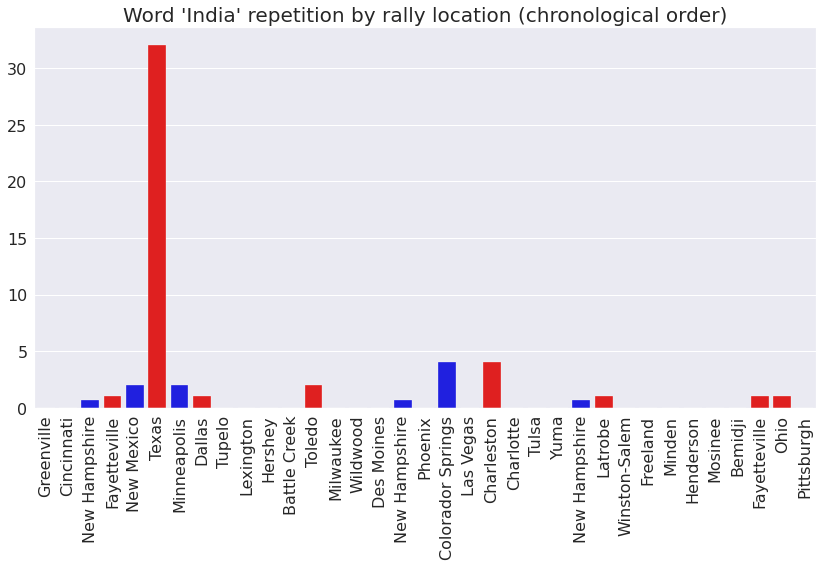

In [25]:
plot_repetition_over_time("India", proper="yes")

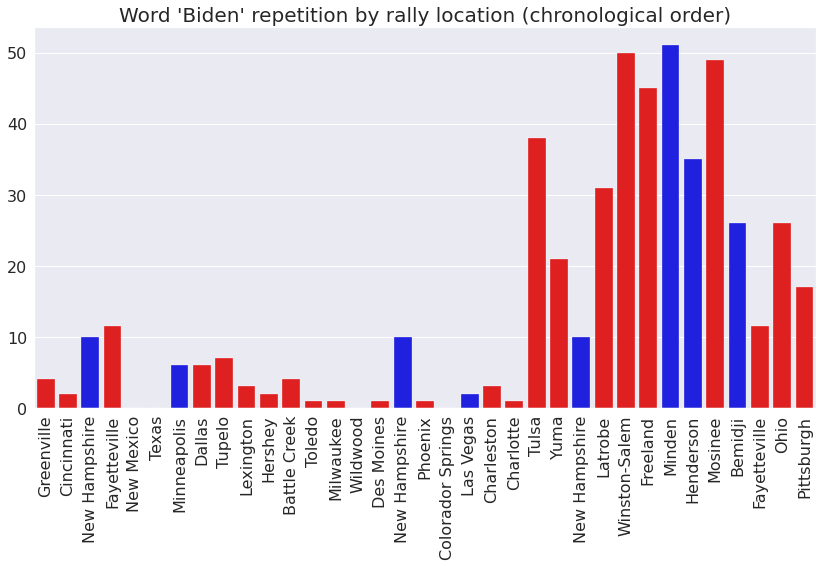

In [26]:
plot_repetition_over_time("Biden", proper="yes")

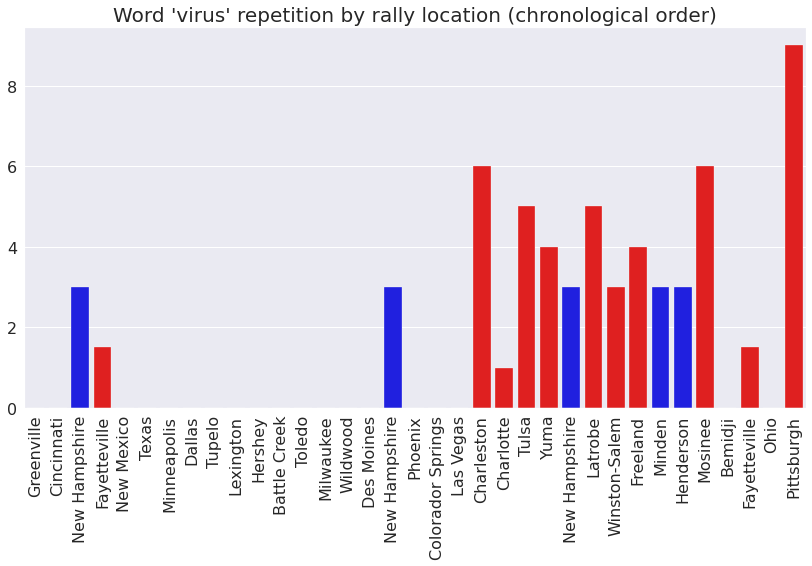

In [27]:
plot_repetition_over_time("virus", proper="no")

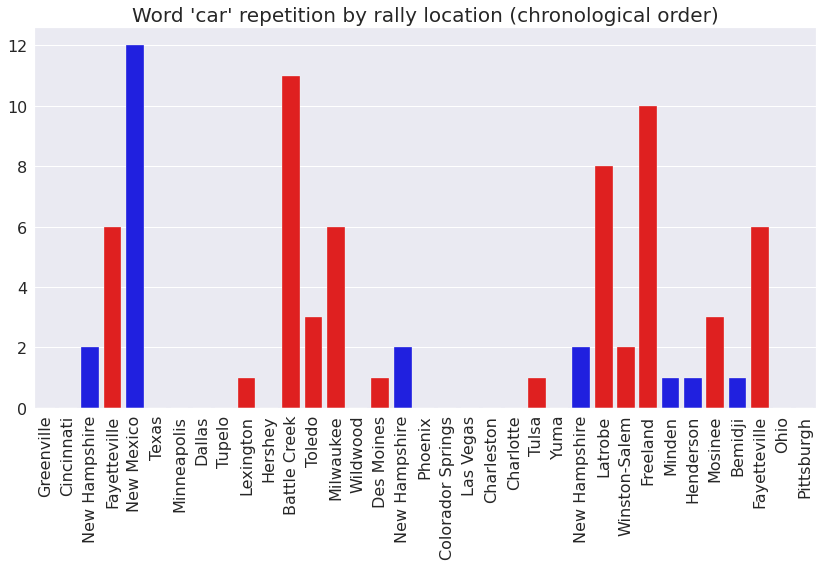

In [28]:
plot_repetition_over_time("car", proper="no")

### 3.2 How two or more words compare in frequency distribution?

In [29]:
def plot_dispersion(target_words, corpus, ignore_case=True, size=(1080, 720)):
    """
    Get lexical dispersion plot of certain word/s over the corpus.
    Dependent on yellowbrick.text.
    
    target_words : list of strings 
        Word/s to plot.
        
    corpus : list
        All words in our data, as returned by all_words().
        
    ignore_case : str, default=True
        Recommended use : "True" with common nouns.
                          "False" with proper names.
        
    size : tuple, default=(1080, 720)
    
    Returns : plot
        Lexical dispersion of the target words.
    """
    dispersion(target_words, corpus, ignore_case=ignore_case, size=size);

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:21: FutureWarning:

arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.



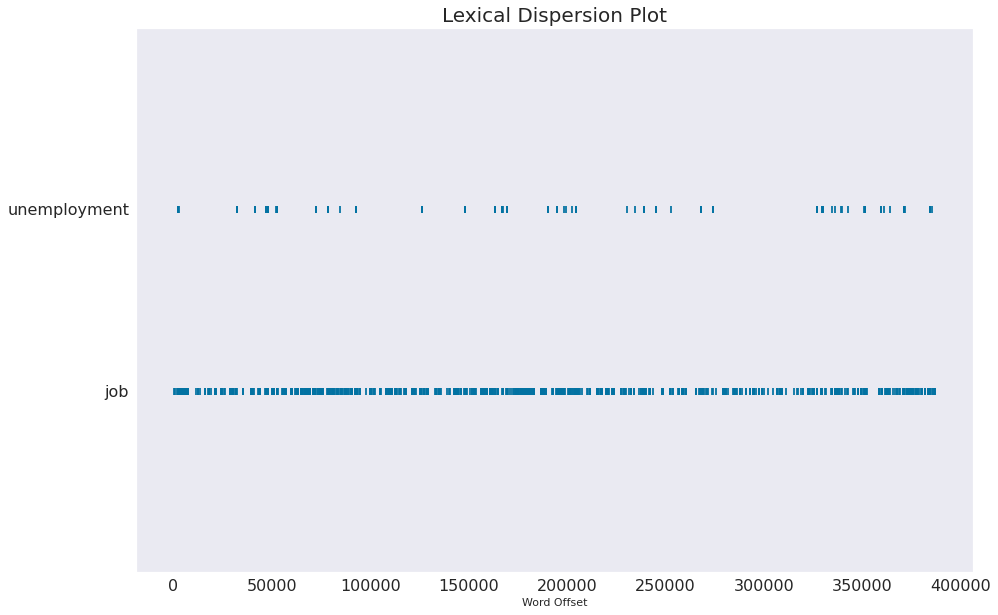

In [32]:
plot_dispersion(['unemployment', 'job'], all_words(speeches))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:21: FutureWarning:

arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.



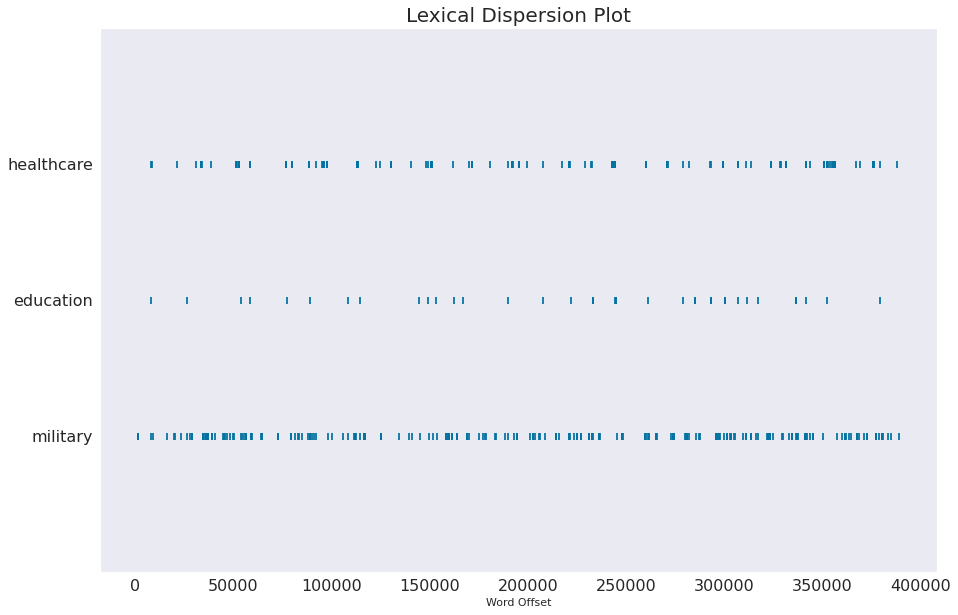

In [33]:
plot_dispersion(['healthcare', 'education', 'military'], all_words(speeches))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:21: FutureWarning:

arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.



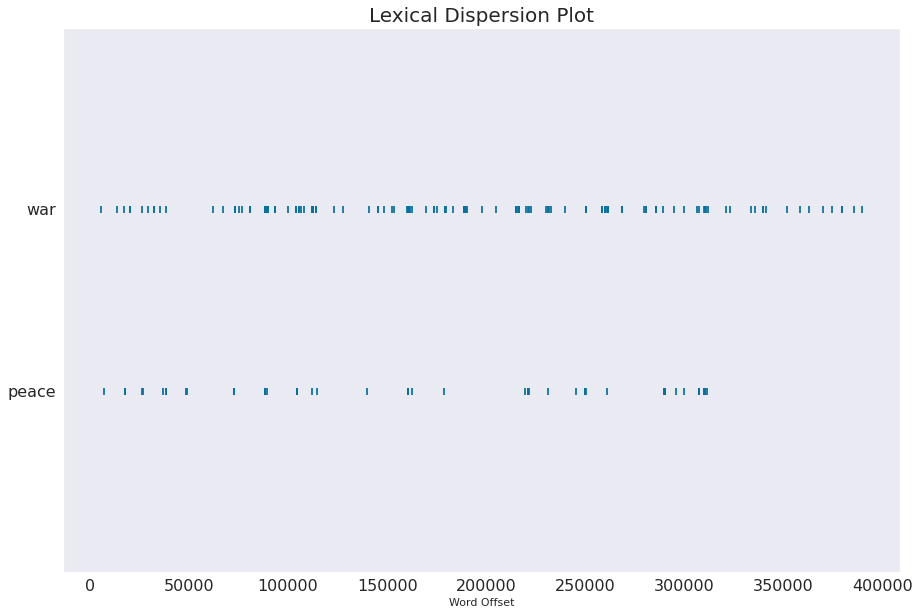

In [34]:
plot_dispersion(['war', 'peace'], all_words(speeches))

### 3.3 Do certain words appear in the same context? 

Another interesting use of this type of plot can be to look for groups of words that may appear in the same context of a given speech. For example, when reading an excerpt of a speech, we can quickly check if some words that appear together in it are repeatedly used together over the speeches.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:21: FutureWarning:

arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.



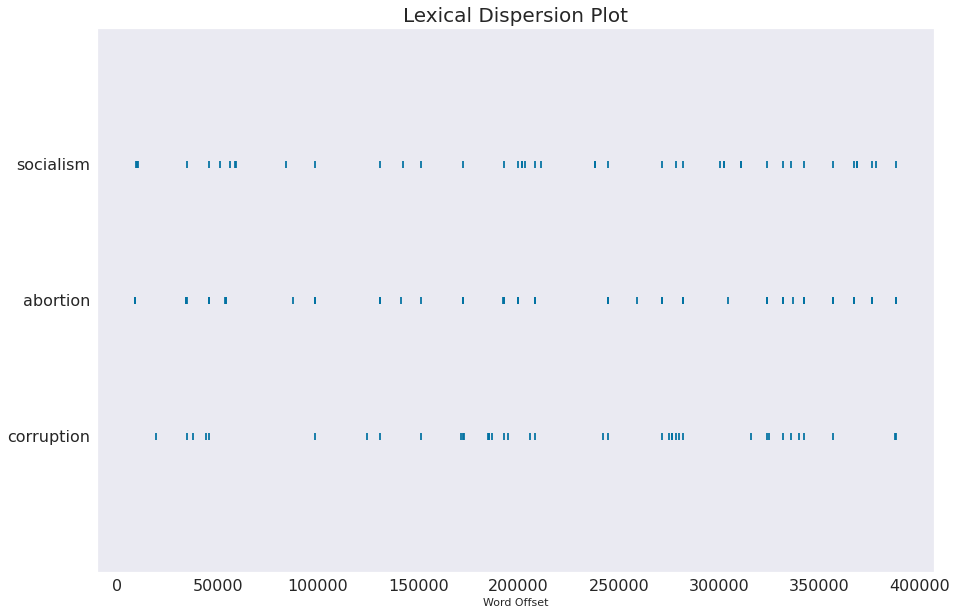

In [35]:
plot_dispersion(['socialism', 'abortion', 'corruption'], all_words(speeches))

# 4. Sentiment

In [36]:
txts = get_speeches(path)

In [37]:
def get_sentiment(doc):
    """
    Get sentiment for each sentence in a document.
    Dependent on nltk.tokenize.sent_tokenize and nltk.sentiment.vader.
    
    doc : txt file
        Speech document.
    
    Returns : list
        Compound rate for each non neutral sentence in the speech as returned by NLTK's polarity_scores().
        
    """
    sia = SentimentIntensityAnalyzer()
    compounds = []
    
    sentences = sent_tokenize(doc)
    for s in sentences:
        c = sia.polarity_scores(s)['compound']
        if c != 0.0:
            compounds.append(c)
    
    return compounds

In [38]:
def overall_sentiment(docs):
    """
    Get average sentiment for each speech and average total for all.
    Dependent on get_sentiment().
    
    docs : txt files
        Speech documents.
    
    Returns : tuple ([avg_per_speech], avg_all_speeches)
        
        - avg_per_speech : list
            Average valence rate for each speech.
        
        - avg_all_speeches : int
            Average valence rate for all speeches.
    """
    
    avg_per_speech = []
    
    for doc in docs:
        compounds = get_sentiment(doc)
        avg_per_speech.append(round(np.mean(compounds), 2))
    
    avg_all_speeches = round(np.mean(avg_per_speech), 2)
    
    return avg_per_speech, avg_all_speeches

### 4.1 Which is the overall sentiment?

In [39]:
avg_speech, avg_all = overall_sentiment(txts)

In [40]:
sentiment_df = pd.DataFrame(
    {"date" : dates,
     "location" : locations,
     "valence": avg_speech
    }).sort_values(by=['date']).reset_index(drop=True)

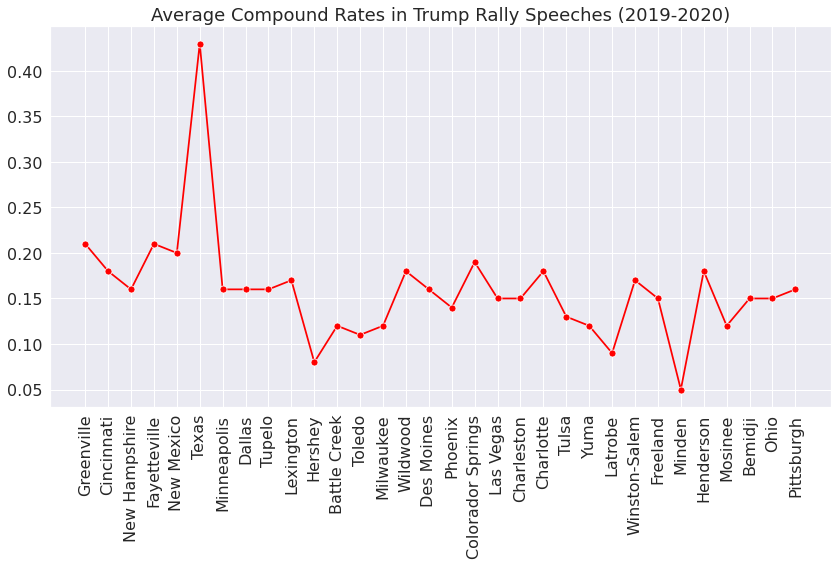

In [59]:
rc = {'axes.titlesize': 20, 
          'xtick.labelsize': 16, 
          'ytick.labelsize': 16}
    
plt.figure(figsize=(14,7))
sns.set_style("darkgrid")
plt.rcParams.update(**rc)

b = sns.lineplot(x=sentiment_df.location, 
                 y=sentiment_df.valence,
                 sort=False,
                 ci=None,
                 color='red',
                 marker='o')
b.axes.set_title('Average Compound Rates in Trump Rally Speeches (2019-2020)',fontsize=18)
plt.xticks(rotation=90)
b.set_xlabel('')
b.set_ylabel('');

Note: compound scores range from -1 (indicating most extreme negative) to 1 (indicating most extreme positive). 

In [60]:
print(f"The average compound rate is of {avg_all}.")

The average compound rate is of 0.16.


### 4.2 Which is the sentiment flow within the speeches? Is there a pattern?

In [43]:
def sentiment_flow_dict(data):
    """
    Create dictionary where values are the list of compounds as given by get_sentiment() and
    the corresponding keys are their length.
    
    data : txt file
        Speech document.
    
    Returns : dict
    """
    
    lengths = []
    flow = dict()
    for d in data:
        compounds = get_sentiment(d)
        arr = np.array([c for c in compounds])
        if len(compounds) in flow.keys():
            if (len(compounds) + 1) not in flow.keys():
                flow[len(compounds) + 1] = np.append(arr, arr[-1])
            else:
                flow[len(compounds) - 1] = arr[:-1]
        else:
            flow[len(compounds)] = arr
                                                  
        lengths.append(len(compounds))
    
    if not len(set(lengths)) == len(lengths):
        print("There're still duplicated keys!")
        
    return flow          

In [44]:
flow_dict = sentiment_flow_dict(txts)

In [45]:
def interpolate(data):
    """
    Normalization of all speeches' length.
    
    data : dict
        sentiment_flow_dict() output.
    
    Returns : list
        Normalized compounds.
    """
    
    maxlength = max(data)
    comps_interp = {k: np.interp(np.linspace(0, 1, maxlength), 
                               np.linspace(0, 1, k), v) 
                  for k, v in data.items()}
    
    return list(comps_interp.values())

In [46]:
interp = interpolate(flow_dict)
transposed = pd.DataFrame(np.array(interp).transpose())

In [47]:
transposed

,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,34
0,0.361200,0.6249,0.421500,0.557400,0.361200,0.361200,0.420100,0.969300,0.612400,0.361200,...,0.361200,0.624900,0.585900,0.361200,0.361200,0.762400,0.557400,0.743000,0.361200,0.557400
1,0.361200,0.3612,0.401114,0.595707,0.361200,0.361200,0.718438,0.885339,0.598545,0.530818,...,0.620221,0.588513,0.439218,0.361200,0.361200,0.549784,0.610235,0.503454,0.482847,0.496346
2,0.407509,0.3612,0.380729,0.626520,0.361200,0.361200,0.805129,0.801378,0.594388,0.625147,...,0.833824,0.548143,0.519095,0.452491,0.361200,0.361200,0.594929,0.361200,0.604494,0.446141
3,0.543013,0.3612,0.367303,0.633330,0.361200,0.361598,0.639443,0.717417,0.691532,0.593770,...,0.715086,0.397604,0.856393,0.624148,0.361200,0.361200,0.571900,0.361200,0.715546,0.514761
4,0.585900,0.8979,0.512471,0.410273,0.441147,0.427131,0.624900,0.633456,0.774469,0.482333,...,0.621638,0.563007,0.699439,0.597897,0.117911,0.392790,0.583399,0.501709,0.825861,0.565090
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
981,0.469893,0.5106,0.361200,0.575076,0.654089,0.585900,0.605128,0.361200,0.416735,0.559116,...,0.601299,0.875928,0.941864,0.531649,0.869238,0.602797,0.361200,0.361200,0.361200,0.927405
982,0.361200,0.4767,0.361200,0.546459,0.533026,0.585900,0.766187,0.361200,0.361200,0.361200,...,0.518349,0.761694,0.943701,0.904612,0.794085,0.516743,0.540895,0.361200,0.361200,0.689802
983,0.361200,0.4404,0.361200,0.396806,0.403284,0.511304,0.488058,0.361200,0.361200,0.361200,...,0.378066,0.829916,0.546934,0.553025,0.448757,0.376995,0.517103,0.361200,0.361200,0.386568
984,0.361200,0.6249,0.361200,0.361200,0.367123,0.436252,0.361200,0.361200,0.361200,0.361200,...,0.361200,0.761828,0.361200,0.361200,0.361200,0.361200,0.361200,0.361200,0.361200,0.361200


In [48]:
def sentiment_flow_viz(df, txt_num=0, window=50, overall=False, title=True):
    """
    Plot sentiment flow in a given rally speech or overall pattern.
    
    df : DataFrame
        Normalized compouns.
    
    txt_num : int, default=0
        Speech number as ordered in the given data to retrieve the location's name.
        
    window : int
        Size of pandas.DataFrame.rolling moving window.
    
    overall : bool, default=False
        If True, returns instead overall pattern.
        
    Returns : plot
        x : number of sentences normalized
        y : sentiment valence range
    """
    
    if overall:
        plt.figure(figsize=(14,7))
        sns.set_style("darkgrid")
        plt.ylim(0, 0.5)

        smooth_data = df.mean(axis=1).rolling(window=window).mean().plot(style='k')
        if title:
            plt.title(f"Sentiment flow overall pattern in Trump's rally speeches",fontsize=20)
        plt.show()
    
    else: 
        plt.figure(figsize=(14,7))
        sns.set_style("darkgrid")
        plt.ylim(-1, 1)

        smooth_data = df[txt_num].rolling(window=window).mean().plot(style='k')
        plt.title(f"Sentiment flow in Trump's {locations[txt_num]} Rally Speech",fontsize=20)
        plt.show()

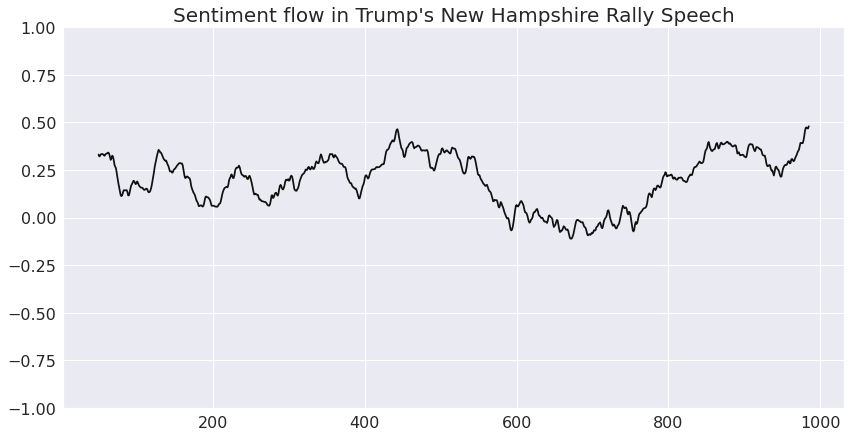

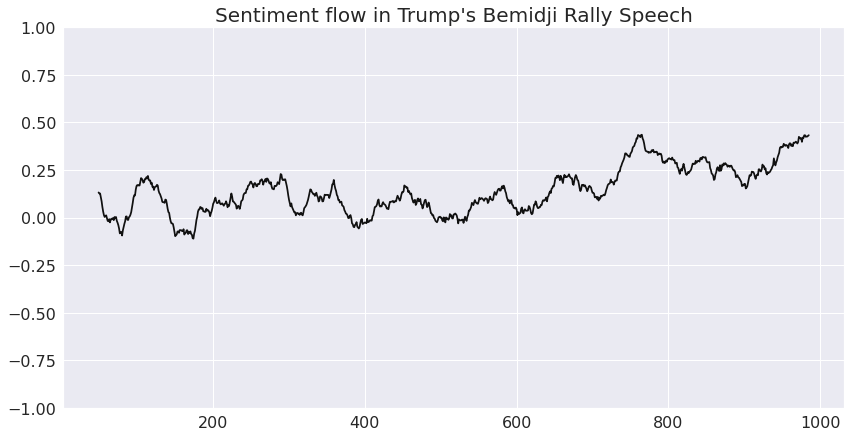

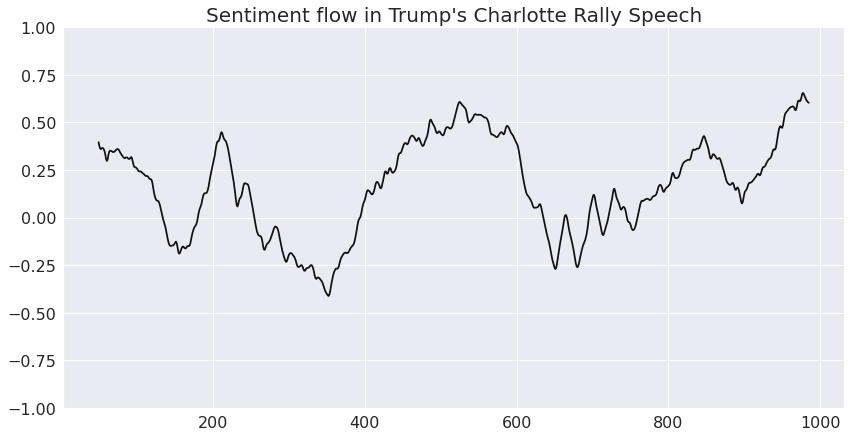

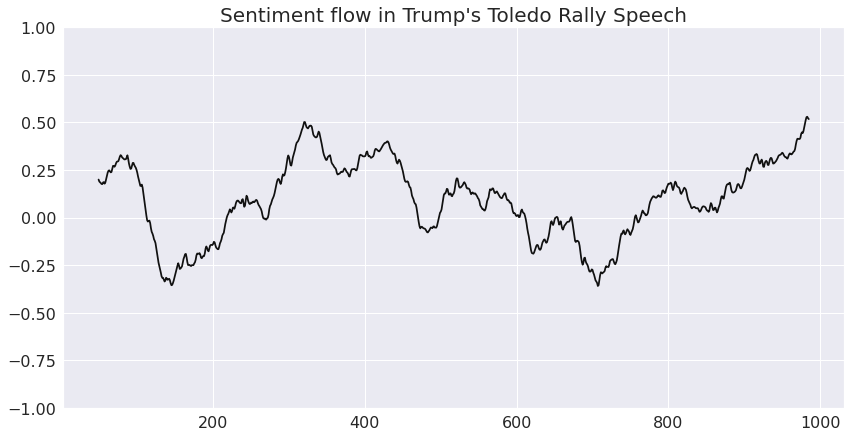

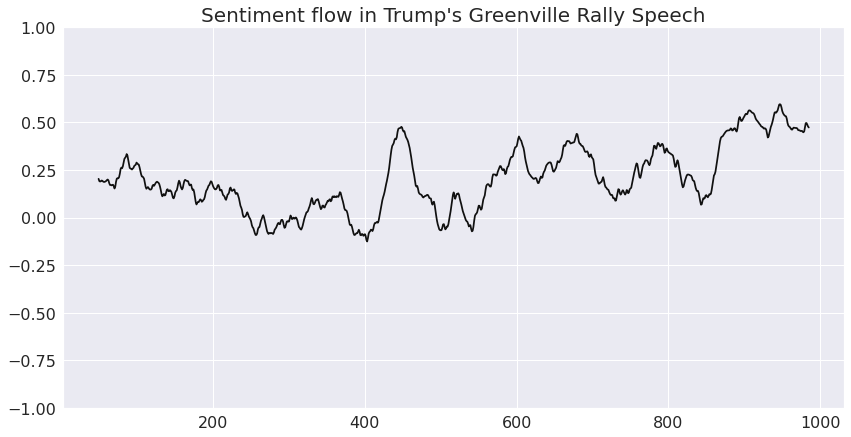

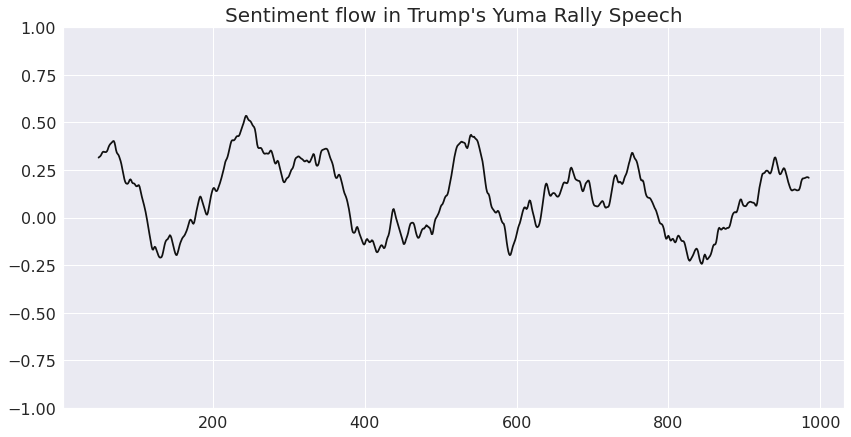

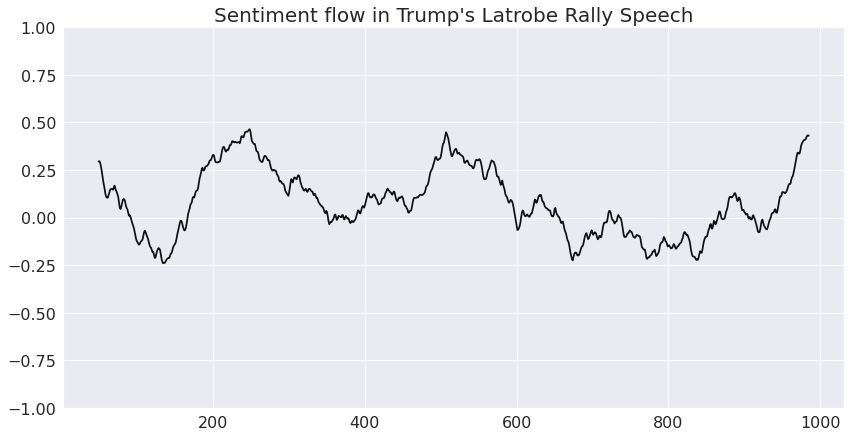

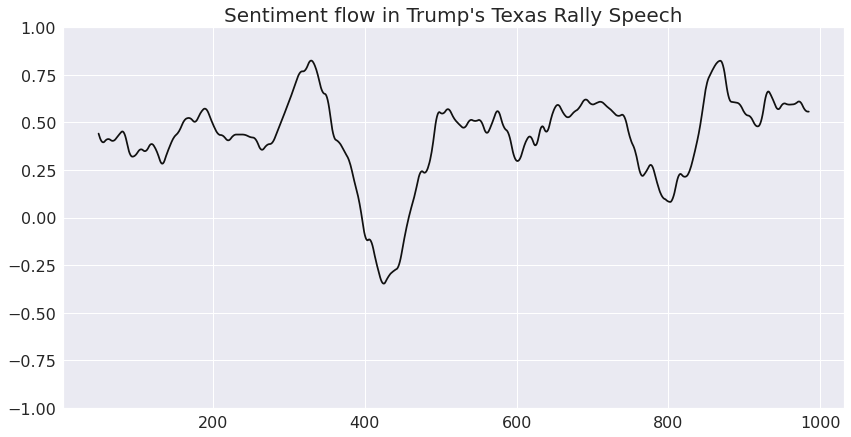

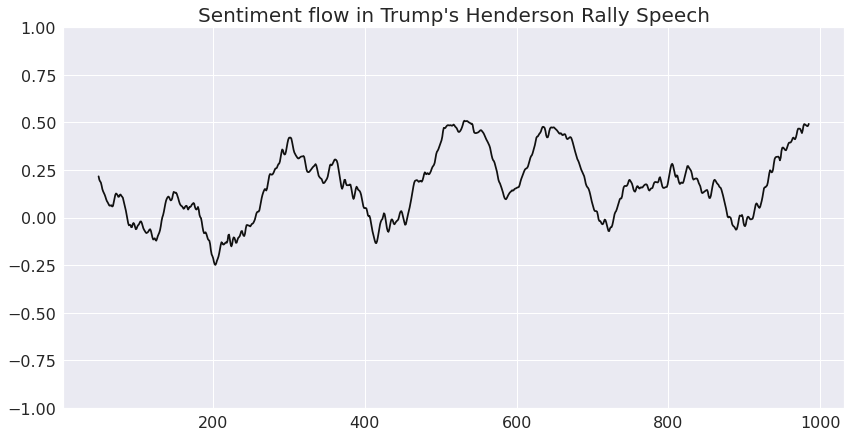

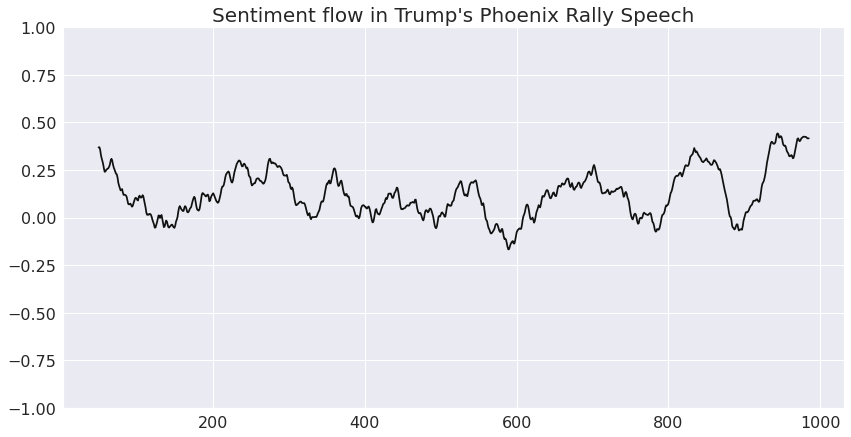

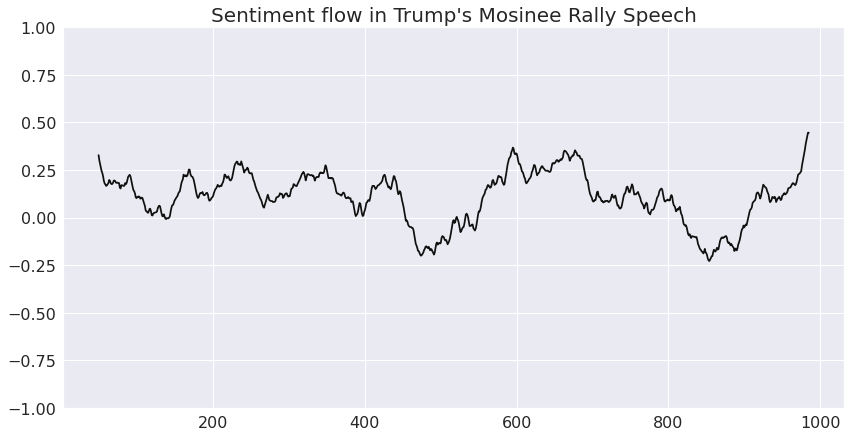

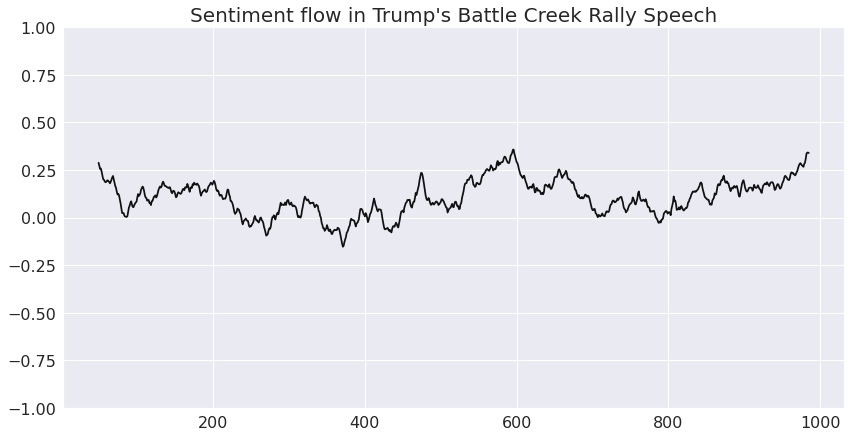

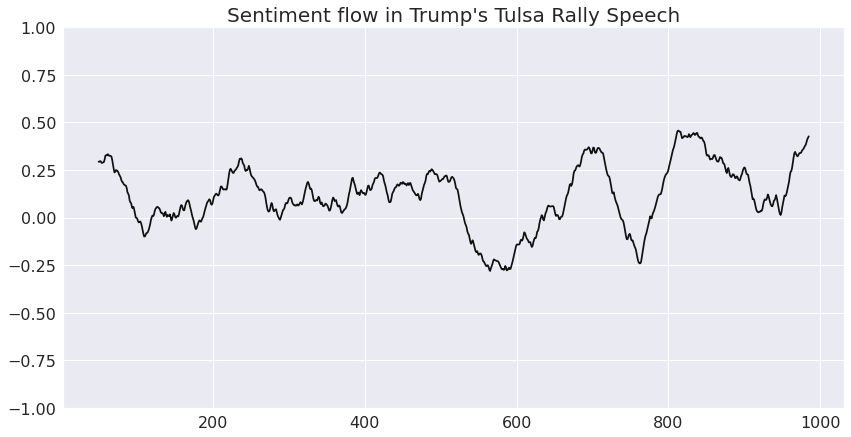

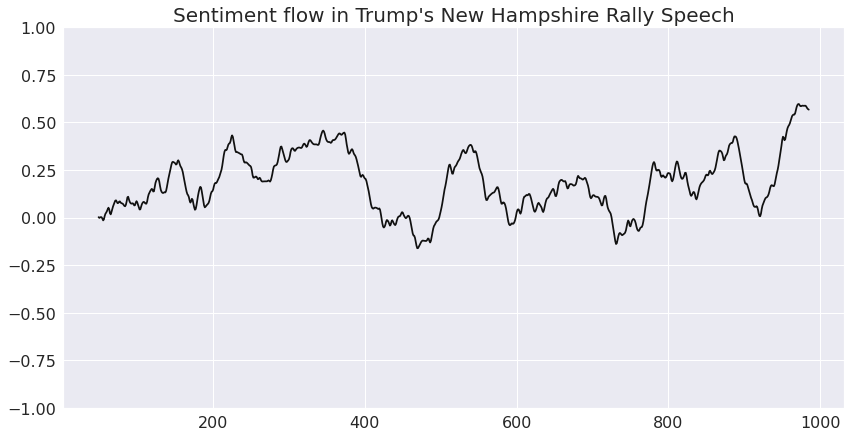

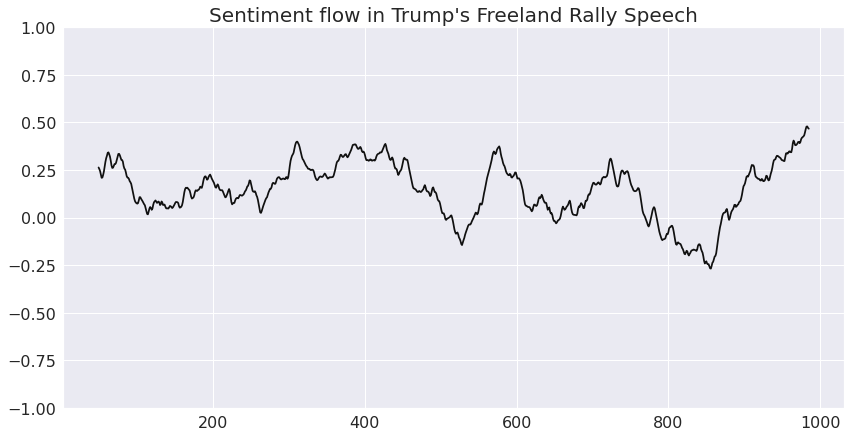

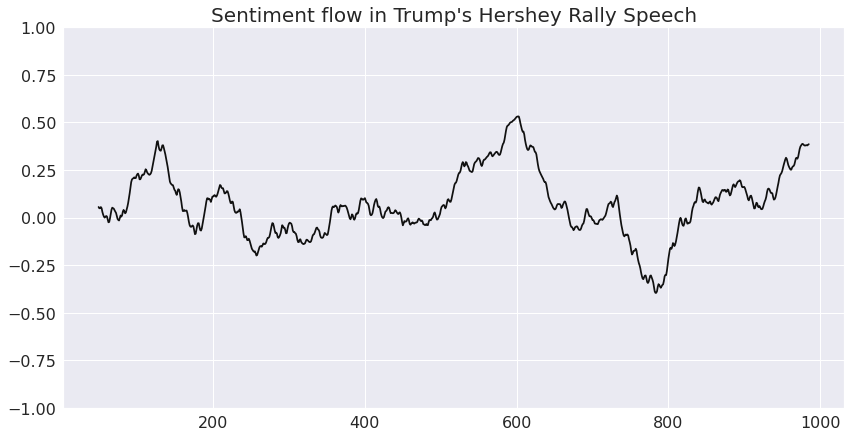

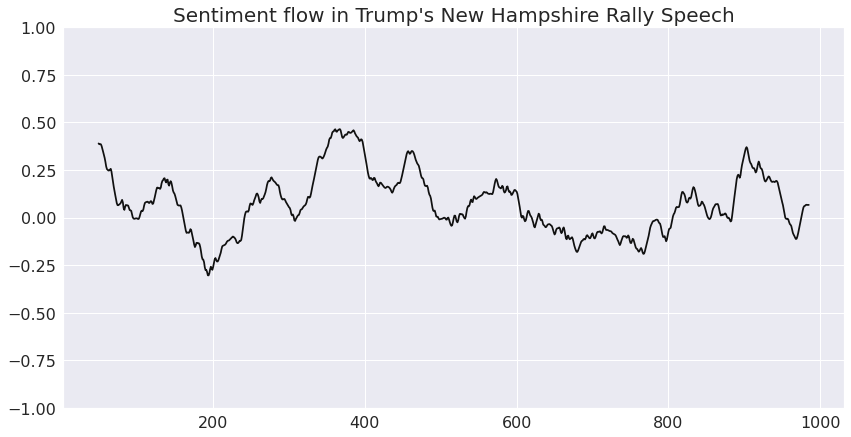

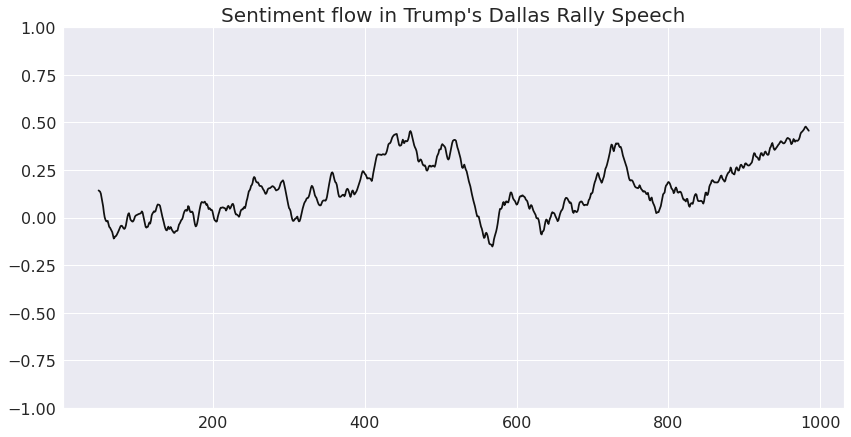

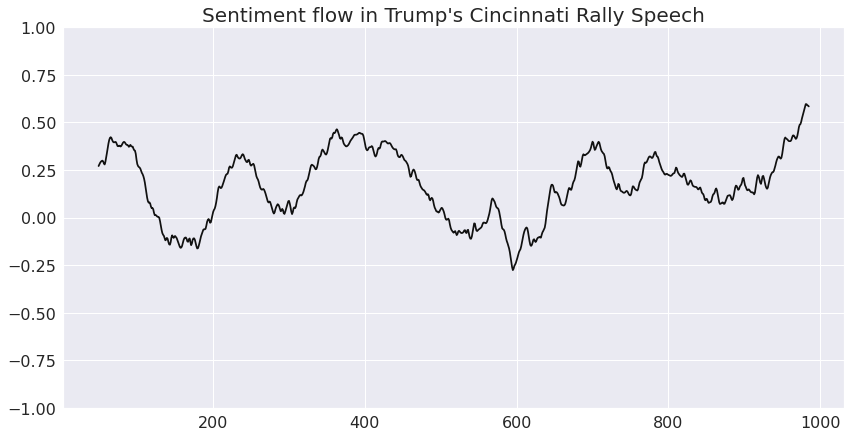

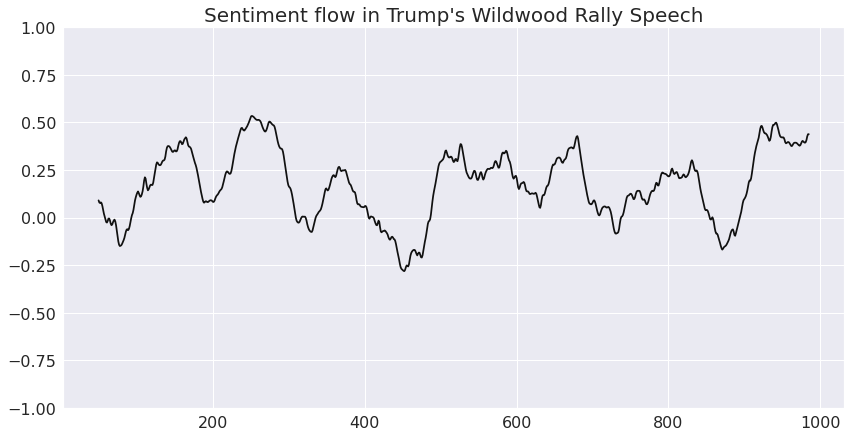

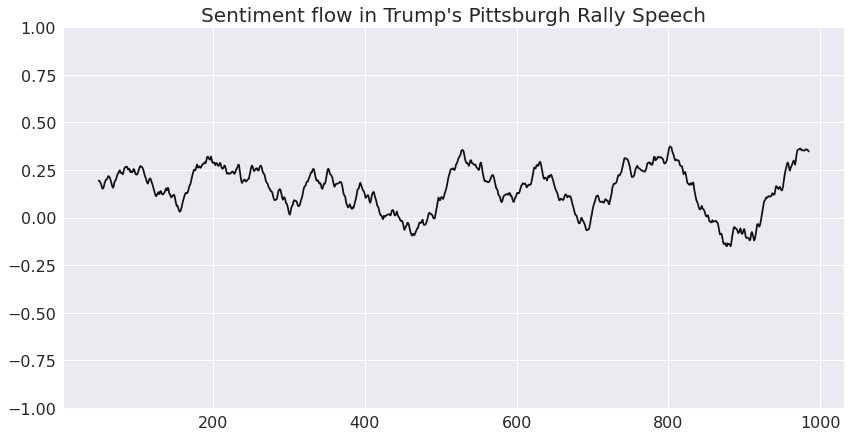

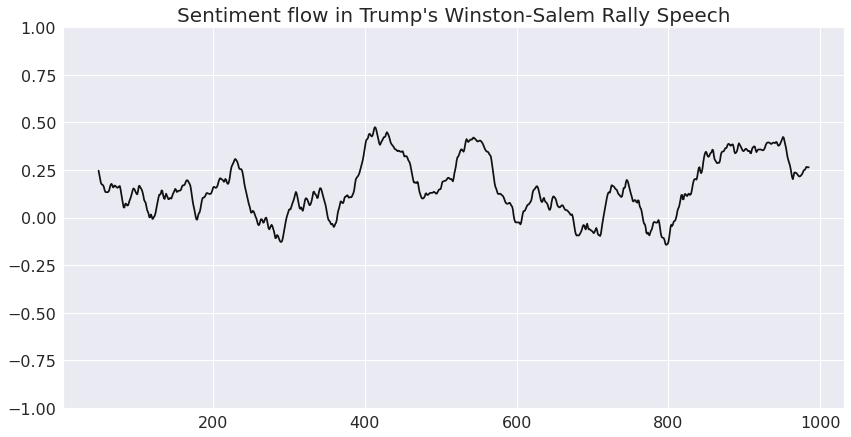

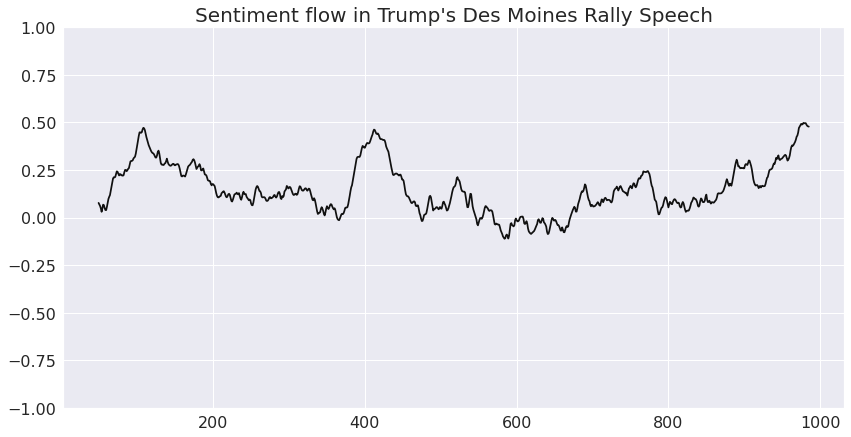

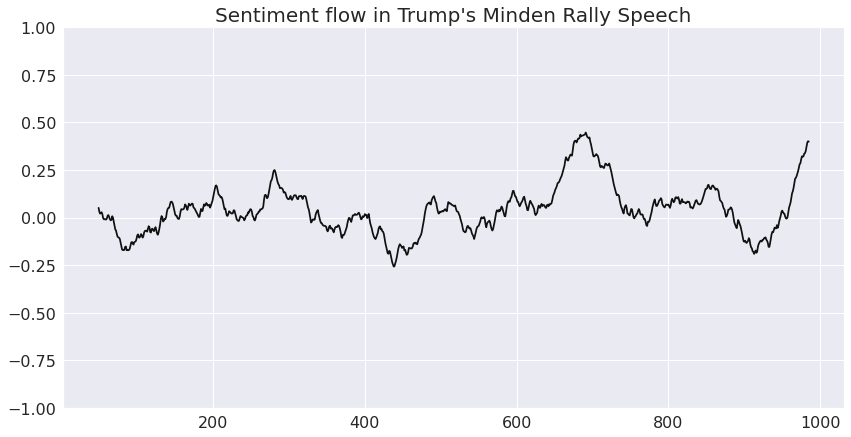

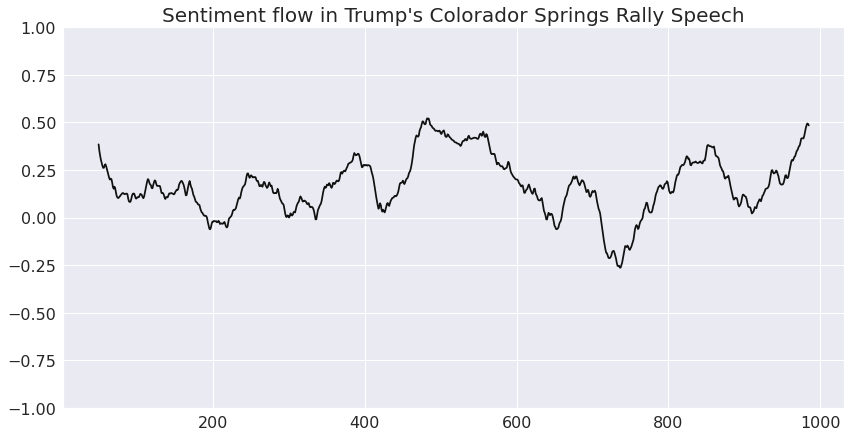

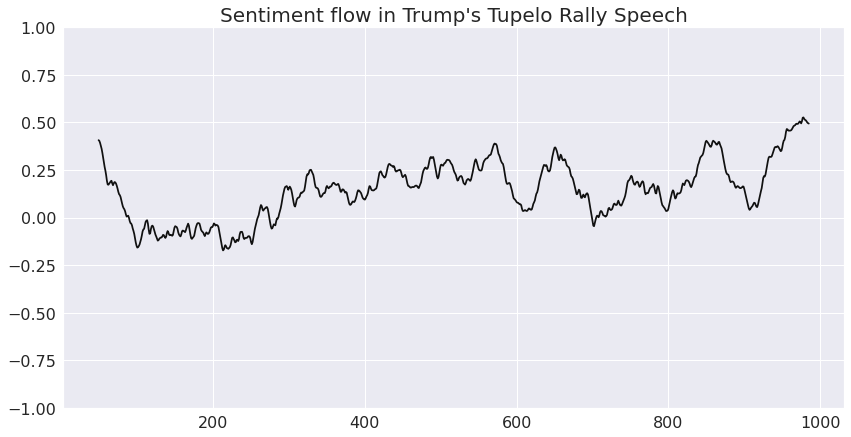

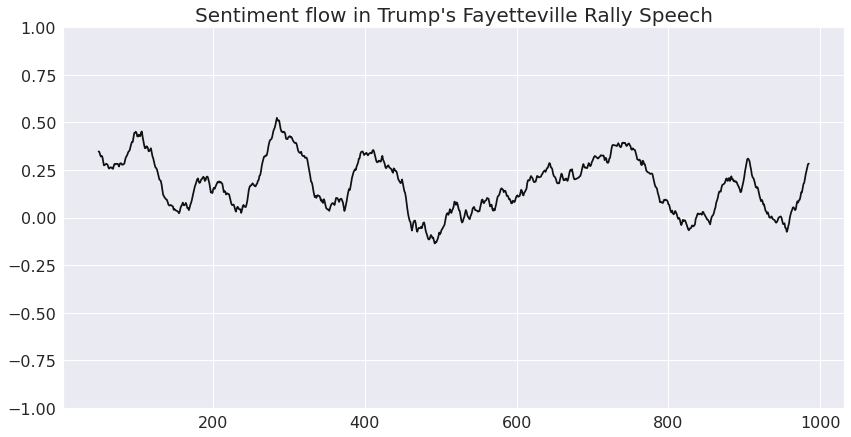

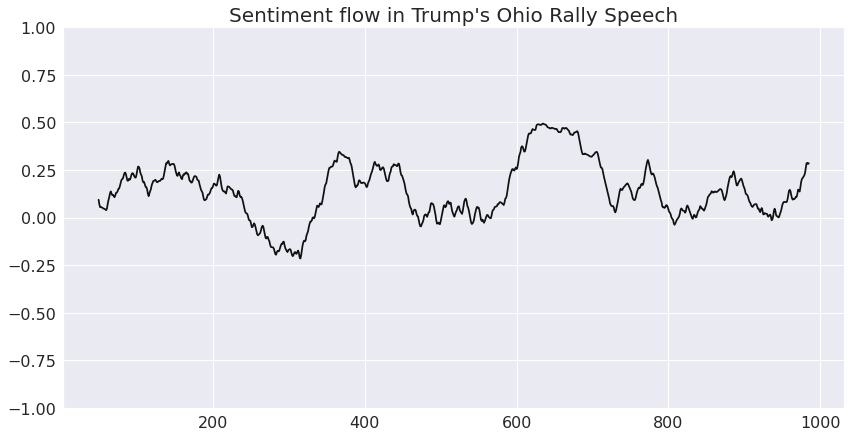

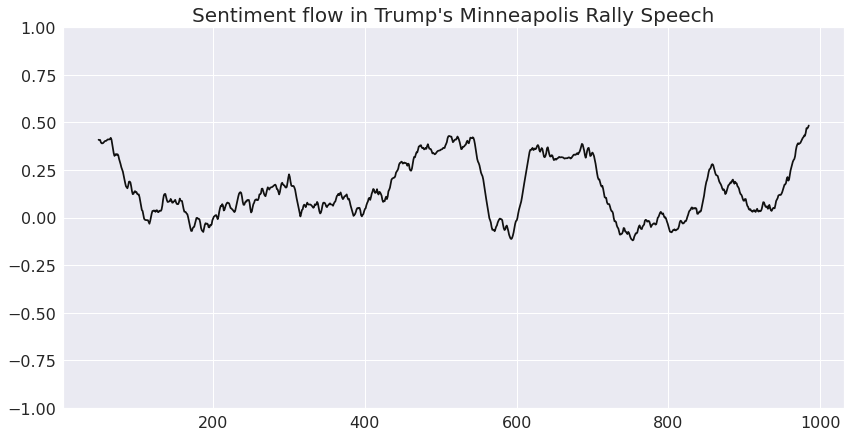

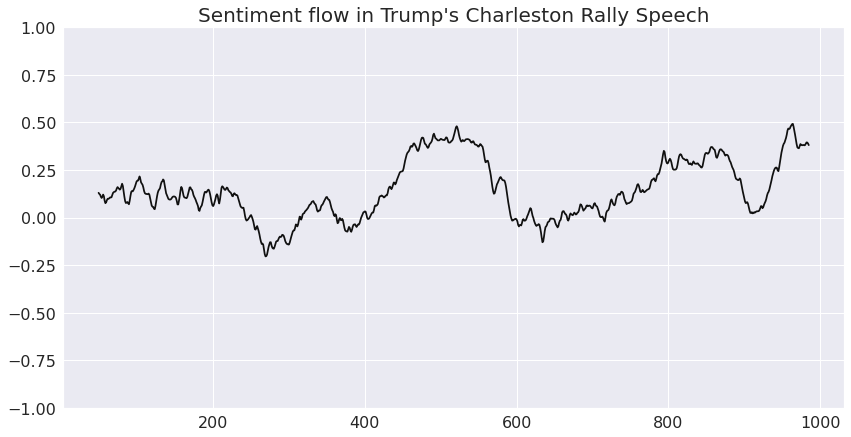

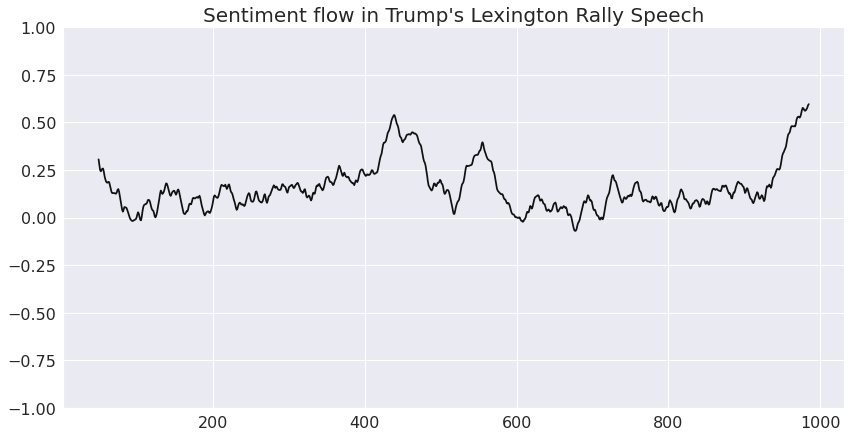

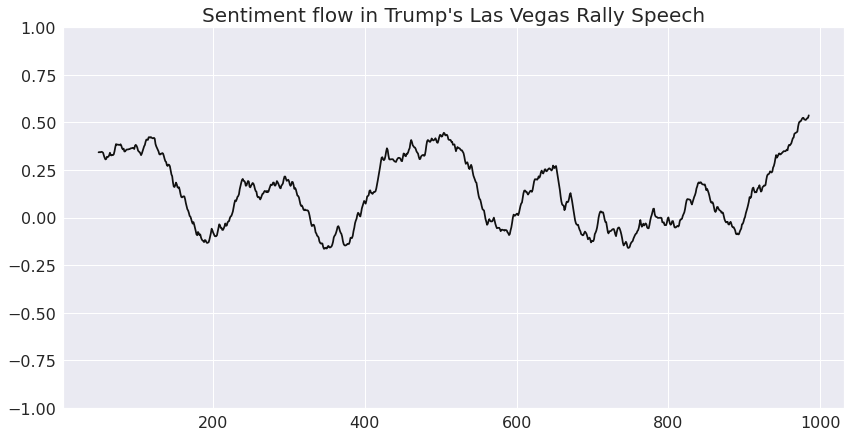

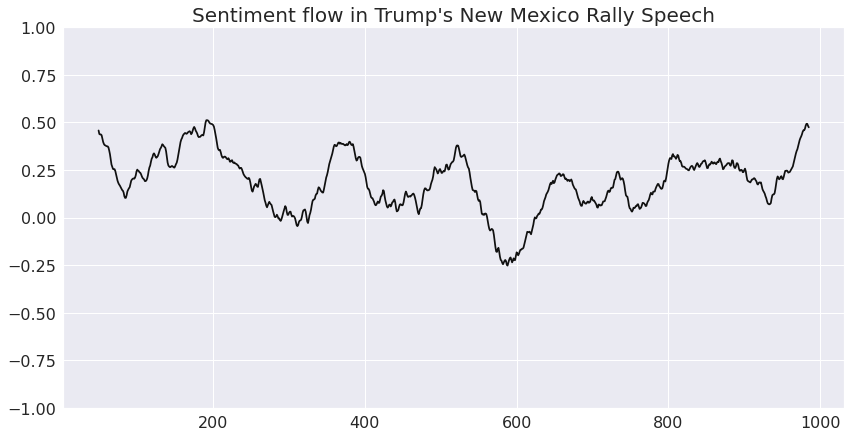

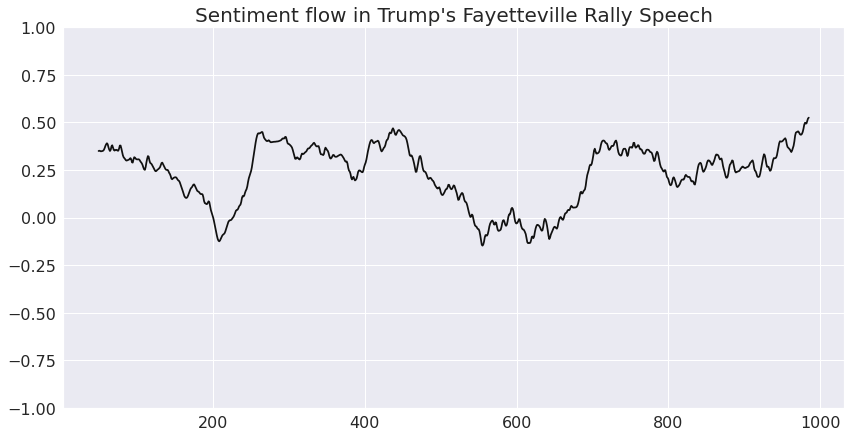

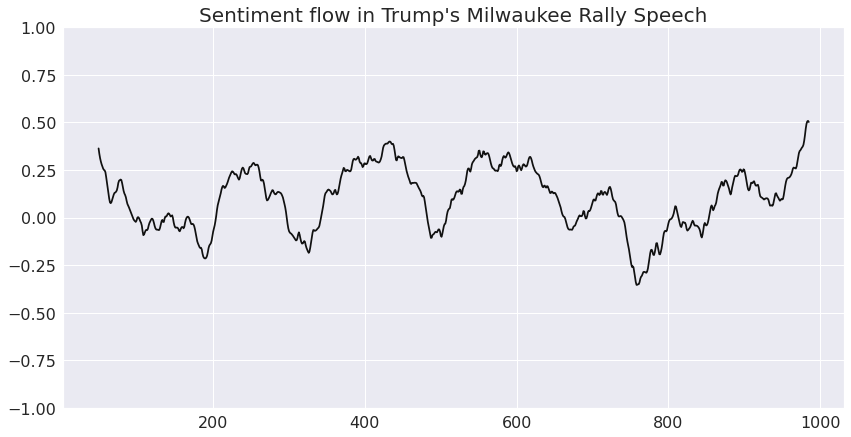

In [49]:
# plots for all rallies
for i in range(len(txts)):
    sentiment_flow_viz(transposed, i)

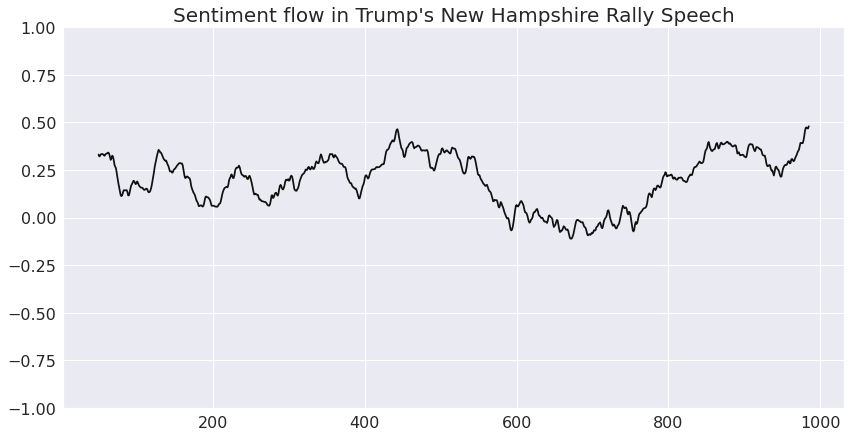

In [50]:
# sample
sentiment_flow_viz(transposed, 0)

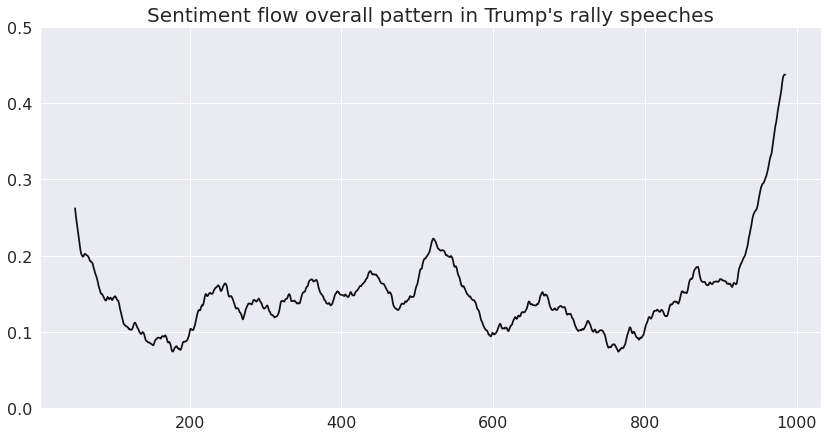

In [51]:
sentiment_flow_viz(transposed, overall=True)

We can use a similar approach to compare the overall pattern for different periods.
<br>For instance, how could affect an event such as the COVID-19 pandemic to this?

In [52]:
# before and after April 2020 condition

before_april = pd.DataFrame()
for i in range(len(txts)):
    if dates[i] < pd.Timestamp(year=2020, month=4, day=1):
        before_april[str(i)] = transposed[i]
        
after_april = pd.DataFrame()
for i in range(len(txts)):
    if dates[i] > pd.Timestamp(year=2020, month=4, day=1):
        after_april[str(i)] = transposed[i]

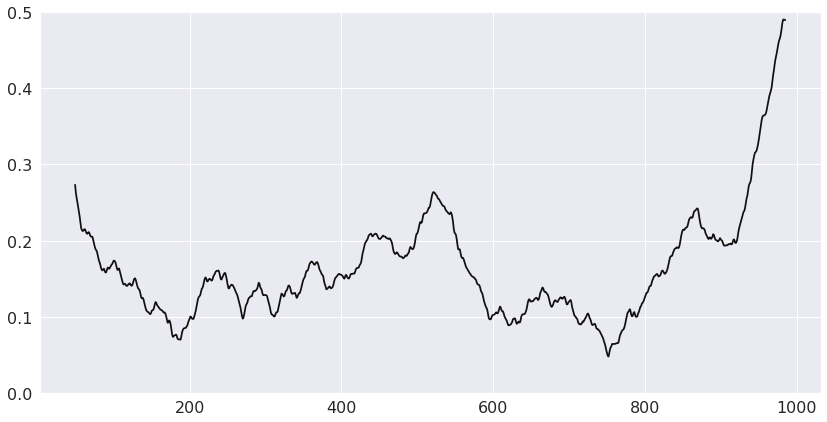

In [53]:
# before April 2020
sentiment_flow_viz(before_april, overall=True, title=False)

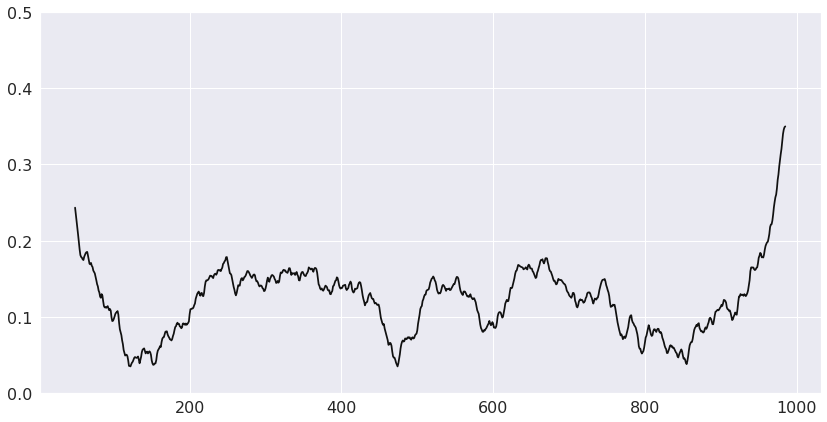

In [54]:
# after April 2020
sentiment_flow_viz(after_april, overall=True, title=False)

### 4.3 Which sentiment usually describes a certain NE?

In [55]:
def NE_sentiment(keywords):
    """
    Valence rate for accompanying adjectives of the given keywords.
    
    keywords : list
        NEs from which we want to know their attributed sentiment.
    
    Returns : DataFrame
    """
    
    def word_compounds(words):
    
        sia = SentimentIntensityAnalyzer()
        compounds = []
        for w in words:
            c = sia.polarity_scores(w)['compound']
            if c != 0.0:
                compounds.append(c)
        return np.array(compounds)
    
    means = []
    for key in keywords:
        words,_,_ = get_acc_words(speeches, key, 'ADJ')
        words = words.split(',')
        mean = round(word_compounds(words).mean(), 2)
        means.append(mean)
    
    df = pd.DataFrame({'keyword': keywords, 'valence': means})
    return df.sort_values(by=['valence']).reset_index(drop=True)
    

In [58]:
NE_sentiment(['Biden', 'Trump', 'Pence', 'Bernie', 'Obama', 'America', 'China'])

,keyword,valence
0,Bernie,-0.15
1,Biden,-0.09
2,Obama,0.07
3,China,0.14
4,Trump,0.23
5,America,0.42
6,Pence,0.54


In [ ]:
## FIN ##